<a href="https://colab.research.google.com/github/sheldonkemper/bank_of_england/blob/main/notebooks/modelling/kk_mvp_modelling_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
===================================================
Author: Kasia Kirby
Role: Reporting Lead, Bank of England Employer Project (Quant Collective)
LinkedIn: https://www.linkedin.com/in/kasia-kirby
Date: 2025-03-05
Version: 2.0

Description:
    This notebook builds a topic modelling and sentiment analysis pipeline
    to analyse two banks' data: JPM and UBS quarterly call trancripts from 2023-2024.

===================================================
"""

"\n===================================================\nAuthor: Kasia Kirby\nRole: Reporting Lead, Bank of England Employer Project (Quant Collective)\nLinkedIn: https://www.linkedin.com/in/kasia-kirby\nDate: 2025-03-05\nVersion: 2.0\n\nDescription:\n    This notebook builds a topic modelling and sentiment analysis pipeline\n    to analyse two banks' data: JPM and UBS quarterly call trancripts from 2023-2024.\n\n===================================================\n"

**Task**

Model the transcript data by analyst and by selected quarters using BERTopic, FinBert and LLM model (Flan-T5).

**Data**

- JMP bank, 2023-2024, Management & Q&A transcripts
- UBS bank, 2023-2024, Management & Q&A transcripts
- preprocessed with pdf parsing, regex-based segmentation, and structured extraction with GPT-4, and converted into a dataframe
- cleaned column added for questions, answers and management text

**Requirements**

1. finBERt returns sentiment accuracy
2. LLM model returns better sentiment accuracy
3. BERTopic performs accurate topic extraction
4. LLM is able to capture more topic context and provide summarisation of those
5. Analyst topics of interest and sentiment varies widely quarter by quarter
6. Topics and sentiment comparison between analysts.

**Approach**

Topic model -> Sentiment analysis -> Insight + Comparison

- First, topics are identified freely by the model on each transcript
- Second the model is trained with G-SIB assessment topics
- Third, sentiment analysis is run on the resulting four files (Q&A and management - with free topics, and trained topics)
- Fourth, all are compared against each other to find best insights
- Evaluation metrics: i. evaluate BERTopic using C_v coherence to ensure well-formed topics, ii. validate FinBERT against a labeled dataset, ii. fine-tune.
- Labelling approach: three sentiment categories, positive (signals optimism and confidence) / neutral (fact-based, balanced) / negative (concerns, risks)

**Benchmark analysis**

- **comparison between model types and their results** (apply like-for-like rules when comparing the models results i.e. if we gather insights on a specific analyst in a specific quarter (Q42024) compare models results and ability to capture correct information using the same analyst and quarter across all models),
- **comparison between Q42024 analyst insights and other quarters insights** (apply full models flow across at least two different periods i.e. Q4 2024 and Q2 2024 and choose a specific analyst and check what major topics and sentiment they cover between the two periods; do they have similar sentiment over time? Do they focus on specific topic areas that are of interest in that specific quarter over the other quarter?),
- **comparison between two different analysts in the same quarter** (are analysts interested in different topics? What can we extract at analyst level with regards to sentiment, topics of interest and conversation summarisation?)



# 1. Import libraries and files

In [58]:
!pip install -q bertopic pyLDAvis nltk bertopic umap-learn hdbscan scikit-learn > /dev/null 2>&1

In [64]:
import os
import sys
from google.colab import drive

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import re
import pickle

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import random
from transformers import pipeline
from sklearn.metrics import confusion_matrix, classification_report

import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.parsing.preprocessing import preprocess_string
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [70]:
# Mount Google Drive to the root location
drive.mount('/content/drive', force_remount=True)
BOE_path = '/content/drive/MyDrive/BOE/bank_of_england/data/preprocessed_data'


Mounted at /content/drive


In [5]:
# Load data

qna_files = {
    "JP Morgan": os.path.join(BOE_path, "jp_morgan_qna.csv"),
    "UBS": os.path.join(BOE_path, "ubs_qa_df_preprocessed_ver2.csv"),
}

management_files = {
    "JP Morgan": os.path.join(BOE_path, "jpmorgan_management_discussion.csv"),
    "UBS": os.path.join(BOE_path, "ubs_management_discussion.csv"),
}

df_qna_jpm = pd.read_csv(qna_files["JP Morgan"], encoding="utf-8")
df_qna_ubs = pd.read_csv(qna_files["UBS"], encoding="utf-8")
df_mgmt_jpm = pd.read_csv(management_files["JP Morgan"], encoding="utf-8")
df_mgmt_ubs = pd.read_csv(management_files["UBS"], encoding="utf-8")

print(" JP Morgan Q&A DataFrame:")
print(df_qna_jpm.info())
display(df_qna_jpm.head())

print("\n UBS Q&A DataFrame:")
print(df_qna_ubs.info())
display(df_qna_ubs.head())

print("\n JP Morgan Management Discussion DataFrame:")
print(df_mgmt_jpm.info())
display(df_mgmt_jpm.head())

print("\n UBS Management Discussion DataFrame:")
print(df_mgmt_ubs.info())
display(df_mgmt_ubs.head())

 JP Morgan Q&A DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Quarter              91 non-null     object
 1   Question             91 non-null     object
 2   Question_cleaned     91 non-null     object
 3   Analyst              91 non-null     object
 4   Analyst Role         91 non-null     object
 5   Response             78 non-null     object
 6   Response_cleaned     91 non-null     object
 7   Executive            88 non-null     object
 8   Executive Role Type  88 non-null     object
dtypes: object(9)
memory usage: 6.5+ KB
None


,Quarter,Question,Question_cleaned,Analyst,Analyst Role,Response,Response_cleaned,Executive,Executive Role Type
0,4Q24,"Hi. Good morning. Jeremy, I wanted to ask abou...",['hi good morning jeremy wanted ask capital kn...,John McDonald,"Analyst, Truist Securities, Inc.","Yeah. Good question, John, and welcome back, b...",['yeah good question john welcome back way so ...,Jeremy Barnum,CFO
1,4Q24,"Hi. Simple and then more difficult, I guess. J...",['hi simple difficult guess jamie whos success...,Mike Mayo,"Analyst, Wells Fargo Securities LLC",I do love what I do. And answering the second ...,['love do answering second question first look...,Jamie Dimon,CEO
2,4Q24,"Hey. Good morning. Maybe just on regulation, w...",['hey good morning maybe regulation new admini...,Jim Mitchell,"Analyst, Seaport Global Securities LLC","Hey, Jim. I mean, it's obviously something we'...",['hey jim mean obviously something thinking lo...,Jeremy Barnum,CFO
3,4Q24,"Yes. Hi, good morning. Wanted to follow up on ...",['yes hi good morning wanted follow questions ...,Erika Najarian,"Analyst, UBS Securities LLC","Right, Erika. Okay. You are tempting me with m...",['right erika okay tempting many rabbit holes ...,Jeremy Barnum,CFO
4,4Q24,"Does that conclude your question, Erika?",['conclude question erika'],Erika,Unknown,Very good. We can go to the next question. Tha...,['good go next question thanks yeah'],Jeremy Barnum,CFO



 UBS Q&A DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   filename          96 non-null     object
 1   Quarter           96 non-null     object
 2   Question          94 non-null     object
 3   Question_cleaned  96 non-null     object
 4   Analyst_Bank      96 non-null     object
 5   Response          91 non-null     object
 6   Response_cleaned  96 non-null     object
 7   Executive         96 non-null     object
dtypes: object(8)
memory usage: 6.1+ KB
None


,filename,Quarter,Question,Question_cleaned,Analyst_Bank,Response,Response_cleaned,Executive
0,1q23-earnings-call-remarks.pdf,1Q23,"Chis Hallam, Goldman Sachs Yes. Good morning, ...",['okay thank you capital requirements know sit...,Goldman,"Okay. Thank you. On capital requirements, you ...",['chis hallam goldman sachs yes good morning e...,['Sergio P. Ermotti']
1,1q23-earnings-call-remarks.pdf,1Q23,Yeah. Thanks. Just two questions. The first on...,['so sarah take first question take secondso g...,JPMorgan,"So, Sarah, take the first question. I'll take ...",['yeah thanks two questions first one related ...,"['Sergio P. Ermotti', 'Sarah Youngwood']"
2,1q23-earnings-call-remarks.pdf,1Q23,"Yeah. Thank you. Good morning. Welcome back, S...",['thank you ryan good back interact well look ...,Bank of America,"Thank you, Ryan. It is good to be back to inte...",['yeah thank you good morning welcome back ser...,['Sergio P. Ermotti']
3,1q23-earnings-call-remarks.pdf,1Q23,Yes. Good morning. The first question I wanted...,['so first question terms trends april really ...,Jefferies,"So, on the first question in terms of the tren...",['yes good morning first question wanted ask r...,"['Sergio P. Ermotti', 'Sarah Youngwood']"
4,1q23-earnings-call-remarks.pdf,1Q23,"Good morning. Two questions. Firstly, just on ...",['so first quarter first question seen signifi...,Citi,"So, on the first quarter or the first question...",['good morning two questions firstly slide 10 ...,['Sarah Youngwood']



 JP Morgan Management Discussion DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Quarter            8 non-null      object
 1   Utterance          8 non-null      object
 2   Utterance_cleaned  8 non-null      object
dtypes: object(3)
memory usage: 324.0+ bytes
None


,Quarter,Utterance,Utterance_cleaned
0,4Q24,MANAGEMENT DISCUSSION SECTION \n \nOperator : ...,['management discussion section operator : goo...
1,3Q24,MANAGEMENT DISCUSSION SECTION \n \n...,['management discussion section operator : goo...
2,2Q24,MANAGEMENT DISCUSSION SECTION \n \n...,['management discussion section operator : goo...
3,1Q24,MANAGEMENT DISCUSSION SECTION \n \n...,['management discussion section operator : goo...
4,4Q23,MANAGEMENT DISCUSSION SECTION \n \n...,['management discussion section operator : goo...



 UBS Management Discussion DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Quarter            34 non-null     object
 1   Speaker            34 non-null     object
 2   Utterance          34 non-null     object
 3   Utterance_cleaned  34 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB
None


,Quarter,Speaker,Utterance,Utterance_cleaned
0,1Q23,Unknown,"Youngwood, Group Chief Financial Officer Inclu...",['youngwood group chief financial officer incl...
1,1Q23,Sergio P. Ermotti,"Thank you, Sarah, good morning, everyone. I am...",['thank you sarah good morning everyone happy ...
2,1Q23,Latin America.,"In Asset Management, the combination will impr...",['asset management combination improve positio...
3,1Q23,Sarah Youngwood,"Thank you, Sergio. Good morning, everyone. rel...",['thank you sergio good morning everyone relat...
4,1Q24,Group Chief Financial Officer,Including analyst Q&A session,['including analyst q&a session']


**Q&A Data**
- Structured into **Questions, Answers, Analysts, and Executives**.
- 13 missing responses in JPM data (this is mainly present in 1Q23 as identified in earlier EDA - ❗**we will keep 1Q23 and make sure to flag missing responses in all downstream analyses**).

**Management Discussion Data**
- Only contains **Quarter-Year and Text** columns, with additional Speaker column in UBS data.

# 2. Data preparation

Add a flag for missing JPM responses, and check for short, non informative JPM and UBS responses.

In [6]:
# Add a flag for missing responses in JPM 1Q23 data

df_qna_jpm["Missing_Response_Flag"] = df_qna_jpm["Response"].isna().astype(int)
df_qna_ubs["Missing_Response_Flag"] = df_qna_ubs["Response"].isna().astype(int)

missing_responses_jpm = df_qna_jpm.groupby("Quarter")["Missing_Response_Flag"].sum()
missing_responses_ubs = df_qna_ubs.groupby("Quarter")["Missing_Response_Flag"].sum()

print("\n Missing Response Summary (JPM Q&A):")
print(missing_responses_jpm)
print(f"\nTotal Missing Responses in JPM: {df_qna_jpm['Missing_Response_Flag'].sum()} out of {len(df_qna_jpm)}")

print("\n Missing Response Summary (UBS Q&A):")
print(missing_responses_ubs)
print(f"\nTotal Missing Responses in UBS: {df_qna_ubs['Missing_Response_Flag'].sum()} out of {len(df_qna_ubs)}")


 Missing Response Summary (JPM Q&A):
Quarter
1Q23    12
1Q24     0
2Q23     1
2Q24     0
3Q23     0
3Q24     0
4Q23     0
4Q24     0
Name: Missing_Response_Flag, dtype: int64

Total Missing Responses in JPM: 13 out of 91

 Missing Response Summary (UBS Q&A):
Quarter
1Q23    0
1Q24    0
2Q23    0
2Q24    2
3Q23    0
3Q24    1
4Q23    1
4Q24    1
Name: Missing_Response_Flag, dtype: int64

Total Missing Responses in UBS: 5 out of 96


In [7]:
# Recheck for short, non-substantive responses as indicated by EDA (separate notebook)

def check_short_responses(df, bank_name):
    df["Response_cleaned"] = df["Response_cleaned"].apply(
        lambda x: str(x).lower().split() if isinstance(x, str) else []
    )

    SHORT_RESPONSE_THRESHOLD = 5
    short_responses = df[df["Response_cleaned"].apply(lambda x: isinstance(x, list) and len(x) <= SHORT_RESPONSE_THRESHOLD)]

    print(f"\n🔍 Checking Short Responses for {bank_name}:")
    print(short_responses[["Quarter", "Response_cleaned"]].head())

    print(f"\n⚠️ Total number of short responses in {bank_name}: {len(short_responses)}")

check_short_responses(df_qna_jpm, "JP Morgan")
check_short_responses(df_qna_ubs, "UBS")


🔍 Checking Short Responses for JP Morgan:
   Quarter                        Response_cleaned
9     4Q24  [['thanks, much, see, next, quarter']]
30    2Q24                         [['questions']]
52    4Q23                   [['questions, time']]
64    3Q23             [['thank, you, questions']]
70    2Q23                               [['nan']]

⚠️ Total number of short responses in JP Morgan: 18

🔍 Checking Short Responses for UBS:
   Quarter            Response_cleaned
40    2Q24        [['morgan, thanks']]
43    2Q24     [['okay, thank, much']]
58    3Q24                      [['']]
69    4Q23                      [['']]
92    4Q24  [['helpful, thank, much']]

⚠️ Total number of short responses in UBS: 5


We will keep short responses as their number is relatively low.

Additionally, we will keep filler words, even if they might seem non-informative (e.g. "think," "little bit," and "obviously"), as they might be useful for sentiment analysis.

# 3. Identify themes with topic modeling (BERTopic)

- Unsupervised BERTopic (extracts natural topics)
- BERTopic trained with G-SIB topics (aligns with regulatory focus)

In line with EDA findings, we will model analyst questions, executive answers and the management discussion separately (to achieve distict themes, that are not inflated by management discussion positivity). We will also retain financial bigrams/trigrams for better context.

## 3a) Prep data for BERTopic

In [8]:
# Tokenise data for BERTopic

# format as strings
df_qna_jpm["Question_cleaned"] = df_qna_jpm["Question_cleaned"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
df_qna_jpm["Response_cleaned"] = df_qna_jpm["Response_cleaned"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

df_qna_ubs["Question_cleaned"] = df_qna_ubs["Question_cleaned"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
df_qna_ubs["Response_cleaned"] = df_qna_ubs["Response_cleaned"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

df_mgmt_jpm["Utterance_cleaned"] = df_mgmt_jpm["Utterance_cleaned"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))
df_mgmt_ubs["Utterance_cleaned"] = df_mgmt_ubs["Utterance_cleaned"].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

# convert into tokenized lists
df_qna_jpm["Question_tokens"] = df_qna_jpm["Question_cleaned"].apply(lambda x: x.split())
df_qna_jpm["Answer_tokens"] = df_qna_jpm["Response_cleaned"].apply(lambda x: x.split())

df_qna_ubs["Question_tokens"] = df_qna_ubs["Question_cleaned"].apply(lambda x: x.split())
df_qna_ubs["Answer_tokens"] = df_qna_ubs["Response_cleaned"].apply(lambda x: x.split())

df_mgmt_jpm["Text_tokens"] = df_mgmt_jpm["Utterance_cleaned"].apply(lambda x: x.split())
df_mgmt_ubs["Text_tokens"] = df_mgmt_ubs["Utterance_cleaned"].apply(lambda x: x.split())

print("\n Tokenized JPM Analyst Question:", df_qna_jpm["Question_tokens"].iloc[0])
print("\n Tokenized JPM Executive Answer:", df_qna_jpm["Answer_tokens"].iloc[0])
print("\n Tokenized JPM Management Discussion:", df_mgmt_jpm["Text_tokens"].iloc[0])

print("\n Tokenized UBS Analyst Question:", df_qna_ubs["Question_tokens"].iloc[0])
print("\n Tokenized UBS Executive Answer:", df_qna_ubs["Answer_tokens"].iloc[0])
print("\n Tokenized UBS Management Discussion:", df_mgmt_ubs["Text_tokens"].iloc[0])


 Tokenized JPM Analyst Question: ["['hi", 'good', 'morning', 'jeremy', 'wanted', 'ask', 'capital', 'know', 'get', 'question', 'lot', 'kind', 'high-class', 'dilemma', 'growing', 'capital', 'base', 'perspective', 'earnings', 'store', 'so', 'guess', 'whats', 'framework', 'thinking', 'opportunity', 'cost', 'sitting', 'growing', 'base', 'capital', 'high', 'might', 'let', 'go', 'versus', 'patience', 'waiting', 'attractive', 'deployment', 'opportunities', 'thank', 'you', 'thanks', 'okay', 'thanks', 'jeremy', 'follow-up', 'think', 'investment', 'spend', 'agenda', 'year', 'differ', 'from', 'say', 'last', 'year', 'last', 'couple', 'years', 'across', 'lines', 'business', 'kind', 'certainty', 'return', 'spectrum', 'talked', 'about', 'kind', 'efficiencies', 'baked', 'outlook', 'well', 'thanks', 'helpful', 'thank', "you']"]

 Tokenized JPM Executive Answer: ["['yeah", 'good', 'question', 'john', 'welcome', 'back', 'way', 'so', 'yeah', 'noted', 'points', 'always', 'make', 'repeat', 'them', 'think', 

Running tokens through ChatGPT gives us an early insight into key themes across both banks (see below)

'JP Morgan and UBS analyst questions center on **capital requirements, liquidity, and regulatory impacts**, with UBS analysts particularly focused on **government guarantees and legal approvals** post-Credit Suisse acquisition.

Executive responses at both banks emphasize **capital deployment, investment strategies, and balancing risk with growth**, while UBS executives highlight **regulatory clarity and future capital buffers**.

Management discussions reveal that JPM provides **detailed earnings breakdowns**, whereas UBS offers **more structured financial summaries**, reflecting different approaches to financial reporting.'

In [9]:
# Remove artifacts

def clean_tokens(token_list):
    if isinstance(token_list, list):
        refined_tokens = []
        for token in token_list:
            token = re.sub(r"â", "", token)  # remove encoding artifacts
            token = re.sub(r"heldtomaturity", "held to maturity", token)
            token = re.sub(r"yearonyear", "year on year", token)
            token = re.sub(r"cohead", "co-head", token)
            token = re.sub(r"typesize", "type size", token)
            token = re.sub(r"[^\w$%&-]", "", token)  # remove unnecessary punctuation
            if token.strip():  # remove empty tokens
                refined_tokens.append(token)
        return refined_tokens
    return token_list

df_qna_jpm["Question_tokens"] = df_qna_jpm["Question_tokens"].apply(clean_tokens)
df_qna_jpm["Answer_tokens"] = df_qna_jpm["Answer_tokens"].apply(clean_tokens)
df_mgmt_jpm["Text_tokens"] = df_mgmt_jpm["Text_tokens"].apply(clean_tokens)

df_qna_ubs["Question_tokens"] = df_qna_ubs["Question_tokens"].apply(clean_tokens)
df_qna_ubs["Answer_tokens"] = df_qna_ubs["Answer_tokens"].apply(clean_tokens)
df_mgmt_ubs["Text_tokens"] = df_mgmt_ubs["Text_tokens"].apply(clean_tokens)

print("\n Cleaned JPM Analyst Question Tokens:", df_qna_jpm["Question_tokens"].iloc[0])
print("\n Cleaned JPM Executive Answer Tokens:", df_qna_jpm["Answer_tokens"].iloc[0])
print("\n Cleaned JPM Management Discussion Tokens:", df_mgmt_jpm["Text_tokens"].iloc[0])

print("\n Cleaned UBS Analyst Question Tokens:", df_qna_ubs["Question_tokens"].iloc[0])
print("\n Cleaned UBS Executive Answer Tokens:", df_qna_ubs["Answer_tokens"].iloc[0])
print("\n Cleaned UBS Management Discussion Tokens:", df_mgmt_ubs["Text_tokens"].iloc[0])


 Cleaned JPM Analyst Question Tokens: ['hi', 'good', 'morning', 'jeremy', 'wanted', 'ask', 'capital', 'know', 'get', 'question', 'lot', 'kind', 'high-class', 'dilemma', 'growing', 'capital', 'base', 'perspective', 'earnings', 'store', 'so', 'guess', 'whats', 'framework', 'thinking', 'opportunity', 'cost', 'sitting', 'growing', 'base', 'capital', 'high', 'might', 'let', 'go', 'versus', 'patience', 'waiting', 'attractive', 'deployment', 'opportunities', 'thank', 'you', 'thanks', 'okay', 'thanks', 'jeremy', 'follow-up', 'think', 'investment', 'spend', 'agenda', 'year', 'differ', 'from', 'say', 'last', 'year', 'last', 'couple', 'years', 'across', 'lines', 'business', 'kind', 'certainty', 'return', 'spectrum', 'talked', 'about', 'kind', 'efficiencies', 'baked', 'outlook', 'well', 'thanks', 'helpful', 'thank', 'you']

 Cleaned JPM Executive Answer Tokens: ['yeah', 'good', 'question', 'john', 'welcome', 'back', 'way', 'so', 'yeah', 'noted', 'points', 'always', 'make', 'repeat', 'them', 'thin

In [10]:
# Remove unnecessary punctuation, conversational tokens and phrases

def advanced_clean_tokens(token_list):
    if isinstance(token_list, list):
        refined_tokens = []
        for token in token_list:
            token = re.sub(r"[$%]", "", token)  # remove $ and %
            token = re.sub(r"\b\d+\b", "", token)  # remove standalone numbers
            token = token.replace("&", "and")
            common_fillers = {"yeah", "good", "morning", "thanks", "thank", "well",
                              "okay", "hi", "welcome", "like", "so", "right", "please"}
            if token.lower() in common_fillers:
                continue
            non_substantive_phrases = {"management", "discussion", "section", "operator",
                                        "presentation", "disclaimer", "call", "recorded", "live"}
            if token.lower() in non_substantive_phrases:
                continue

            if token.strip():
                refined_tokens.append(token)

        return refined_tokens
    return token_list

df_qna_jpm["Question_tokens"] = df_qna_jpm["Question_tokens"].apply(advanced_clean_tokens)
df_qna_jpm["Answer_tokens"] = df_qna_jpm["Answer_tokens"].apply(advanced_clean_tokens)
df_qna_ubs["Question_tokens"] = df_qna_ubs["Question_tokens"].apply(advanced_clean_tokens)
df_qna_ubs["Answer_tokens"] = df_qna_ubs["Answer_tokens"].apply(advanced_clean_tokens)
df_mgmt_jpm["Text_tokens"] = df_mgmt_jpm["Text_tokens"].apply(advanced_clean_tokens)
df_mgmt_ubs["Text_tokens"] = df_mgmt_ubs["Text_tokens"].apply(advanced_clean_tokens)

print("\n Further Cleaned JPM Analyst Question Tokens:", df_qna_jpm["Question_tokens"].iloc[0])
print("\n Further Cleaned JPM Executive Answer Tokens:", df_qna_jpm["Answer_tokens"].iloc[0])
print("\n Further Cleaned JPM Management Discussion Tokens:", df_mgmt_jpm["Text_tokens"].iloc[0])
print("\n Further Cleaned UBS Analyst Question Tokens:", df_qna_ubs["Question_tokens"].iloc[0])
print("\n Further Cleaned UBS Executive Answer Tokens:", df_qna_ubs["Answer_tokens"].iloc[0])
print("\n Further Cleaned UBS Management Discussion Tokens:", df_mgmt_ubs["Text_tokens"].iloc[0])


 Further Cleaned JPM Analyst Question Tokens: ['jeremy', 'wanted', 'ask', 'capital', 'know', 'get', 'question', 'lot', 'kind', 'high-class', 'dilemma', 'growing', 'capital', 'base', 'perspective', 'earnings', 'store', 'guess', 'whats', 'framework', 'thinking', 'opportunity', 'cost', 'sitting', 'growing', 'base', 'capital', 'high', 'might', 'let', 'go', 'versus', 'patience', 'waiting', 'attractive', 'deployment', 'opportunities', 'you', 'jeremy', 'follow-up', 'think', 'investment', 'spend', 'agenda', 'year', 'differ', 'from', 'say', 'last', 'year', 'last', 'couple', 'years', 'across', 'lines', 'business', 'kind', 'certainty', 'return', 'spectrum', 'talked', 'about', 'kind', 'efficiencies', 'baked', 'outlook', 'helpful', 'you']

 Further Cleaned JPM Executive Answer Tokens: ['question', 'john', 'back', 'way', 'noted', 'points', 'always', 'make', 'repeat', 'them', 'think', 'way', 'thinking', 'feel', 'comfortable', 'notion', 'makes', 'sense', 'us', 'nice', 'store', 'extra', 'capital', 'li

In [11]:
# Convert token lists back to full sentences for Q&A

df_qna_jpm["Question_processed"] = df_qna_jpm["Question_tokens"].apply(lambda x: " ".join(x))
df_qna_jpm["Answer_processed"] = df_qna_jpm["Answer_tokens"].apply(lambda x: " ".join(x))

df_qna_ubs["Question_processed"] = df_qna_ubs["Question_tokens"].apply(lambda x: " ".join(x))
df_qna_ubs["Answer_processed"] = df_qna_ubs["Answer_tokens"].apply(lambda x: " ".join(x))

# exclude missing JPM responses using our flag
df_qna_jpm_filtered = df_qna_jpm[df_qna_jpm["Missing_Response_Flag"] == 0].copy()
removed_responses_count = df_qna_jpm["Missing_Response_Flag"].sum()
print(f"\n Total JPM Responses Removed Due to Missing Flag: {removed_responses_count}")

# extract text lists for BERTopic
analyst_questions_jpm = df_qna_jpm_filtered["Question_processed"].tolist()  # filter questions
executive_answers_jpm = df_qna_jpm_filtered["Answer_processed"].tolist()  # filter answers

analyst_questions_ubs = df_qna_ubs["Question_processed"].tolist()
executive_answers_ubs = df_qna_ubs["Answer_processed"].tolist()

# final counts
print("\n Final JPM Analyst Questions Count:", len(analyst_questions_jpm))
print(" Final JPM Executive Answers Count (Filtered):", len(executive_answers_jpm))
print(" Final UBS Analyst Questions Count:", len(analyst_questions_ubs))
print(" Final UBS Executive Answers Count:", len(executive_answers_ubs))

# sample data
print("\n Sample JPM Analyst Question (Final for BERTopic):", analyst_questions_jpm[:2])
print("\n Sample UBS Analyst Question (Final for BERTopic):", analyst_questions_ubs[:2])

print("\n Sample JPM Executive Answer (Final for BERTopic):", executive_answers_jpm[:2])
print("\n Sample UBS Executive Answer (Final for BERTopic):", executive_answers_ubs[:2])


 Total JPM Responses Removed Due to Missing Flag: 13

 Final JPM Analyst Questions Count: 78
 Final JPM Executive Answers Count (Filtered): 78
 Final UBS Analyst Questions Count: 96
 Final UBS Executive Answers Count: 96

 Sample JPM Analyst Question (Final for BERTopic): ['jeremy wanted ask capital know get question lot kind high-class dilemma growing capital base perspective earnings store guess whats framework thinking opportunity cost sitting growing base capital high might let go versus patience waiting attractive deployment opportunities you jeremy follow-up think investment spend agenda year differ from say last year last couple years across lines business kind certainty return spectrum talked about kind efficiencies baked outlook helpful you', 'simple difficult guess jamie whos successor second question is know asked question investor day stay ceo little bit longer think hearing investors now goes down think investors would stay say going stay less five years finally getting w

In [12]:
# Convert token lists back to full sentences for Management Discussion
df_mgmt_jpm["Text_processed"] = df_mgmt_jpm["Text_tokens"].apply(lambda x: " ".join(x))
df_mgmt_ubs["Text_processed"] = df_mgmt_ubs["Text_tokens"].apply(lambda x: " ".join(x))

management_discussion_jpm = df_mgmt_jpm["Text_processed"].tolist()
management_discussion_ubs = df_mgmt_ubs["Text_processed"].tolist()

print("\n Sample JPM Management Discussion (Final for BERTopic):", management_discussion_jpm[:2])
print("\n Sample UBS Management Discussion (Final for BERTopic):", management_discussion_ubs[:2])


 Sample JPM Management Discussion (Final for BERTopic): ['ladies gentlemen jpmorganchases fourth quarter earnings line muted duration go available jpmorganchases website refer back concerning forward-looking statements stand time would turn jpmorganchases chairman ceo jamie dimon chief financial officer jeremy barnum mr barnum go ahead jeremy barnum chief financial officer jpmorganchase you everyone starting page firm reported net income billion eps revenue billion rotce page fourth-quarter results firm reported revenue billion billion year-on-year nii ex markets million driven impact lower rates associated deposit margin compression lower deposit balances ccb largely offset impact securities reinvestment higher revolving balances card higher wholesale deposit balances nir ex markets billion excluding prior years net investment securities losses largely higher asset fees investment banking fees markets revenue billion expenses billion billion year-on-year excluding prior years fdic sp

In [13]:
# Chunk management data for both JPM and UBS

def split_text_by_words(text, chunk_size=100):
    words = text.split()
    chunks = [" ".join(words[i : i + chunk_size]) for i in range(0, len(words), chunk_size)]
    return chunks

expanded_mgmt_jpm = []
expanded_mgmt_ubs = []

for entry in management_discussion_jpm:
    expanded_mgmt_jpm.extend(split_text_by_words(entry, chunk_size=100))

for entry in management_discussion_ubs:
    expanded_mgmt_ubs.extend(split_text_by_words(entry, chunk_size=100))

print(f"\n JPM Management Discussion expanded from {len(management_discussion_jpm)} to {len(expanded_mgmt_jpm)} entries.")
print(f"\n UBS Management Discussion expanded from {len(management_discussion_ubs)} to {len(expanded_mgmt_ubs)} entries.")


 JPM Management Discussion expanded from 8 to 100 entries.

 UBS Management Discussion expanded from 34 to 279 entries.


**Note**: We set 100-word chunks that are small enough to extract distinct topics and large enough to preserve context. We then ensured each chunk inherits the correct quarter.

In [14]:
# Update df_mgmt to include chunks

df_mgmt_expanded_jpm = pd.DataFrame({"Text_processed": expanded_mgmt_jpm})
df_mgmt_expanded_ubs = pd.DataFrame({"Text_processed": expanded_mgmt_ubs})

df_mgmt_expanded_jpm["Quarter"] = np.repeat(
    df_mgmt_jpm["Quarter"].values,
    np.ceil(len(df_mgmt_expanded_jpm) / len(df_mgmt_jpm)).astype(int)
)[:len(df_mgmt_expanded_jpm)]

df_mgmt_expanded_ubs["Quarter"] = np.repeat(
    df_mgmt_ubs["Quarter"].values,
    np.ceil(len(df_mgmt_expanded_ubs) / len(df_mgmt_ubs)).astype(int)
)[:len(df_mgmt_expanded_ubs)]

print("\n JPM Management Discussion updated to match expanded discussion!")
print(df_mgmt_expanded_jpm.head(3))

print("\n UBS Management Discussion updated to match expanded discussion!")
print(df_mgmt_expanded_ubs.head(3))

management_discussion = expanded_mgmt_jpm + expanded_mgmt_ubs


 JPM Management Discussion updated to match expanded discussion!
                                      Text_processed Quarter
0  ladies gentlemen jpmorganchases fourth quarter...    4Q24
1  net investment securities losses largely highe...    4Q24
2  sheet capital page ended quarter cet1 ratio ba...    4Q24

 UBS Management Discussion updated to match expanded discussion!
                                      Text_processed Quarter
0  youngwood group chief financial officer includ...    1Q23
1  you sarah everyone happy back you honor privil...    1Q23
2  prepared part solution rescue credit suisse co...    1Q23


## 3b) Generate topics with BERTopic

In [15]:
# Data check

print("\n Final Data Overview Per Bank:")
print(f"- JPM Analyst Questions: {len(analyst_questions_jpm)}")
print(f"- UBS Analyst Questions: {len(analyst_questions_ubs)}")

print(f"- JPM Executive Answers: {len(executive_answers_jpm)}")
print(f"- UBS Executive Answers: {len(executive_answers_ubs)}")

print(f"- JPM Management Discussion Entries: {len(expanded_mgmt_jpm)}")
print(f"- UBS Management Discussion Entries: {len(expanded_mgmt_ubs)}")


 Final Data Overview Per Bank:
- JPM Analyst Questions: 78
- UBS Analyst Questions: 96
- JPM Executive Answers: 78
- UBS Executive Answers: 96
- JPM Management Discussion Entries: 100
- UBS Management Discussion Entries: 279


In [16]:
# Define BERTopic model

# UMAP for dimensionality reduction
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')

# HDBSCAN for clustering
hdbscan_model = HDBSCAN(
    min_cluster_size=3,  # lower to allow smaller clusters, as running on a small subset actually got bertopic to work
    min_samples=1,       # reduce strictness on outliers to allow the full set to run
    metric="euclidean",
    cluster_selection_method="eom"
)

# CountVectorizer to retain financial bigrams & trigrams
vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english")

In [17]:
# Test sentence embeddings for an example set (UBS questions)

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")  # same one BERTopic uses

question_embeddings = embedding_model.encode(analyst_questions_ubs, show_progress_bar=False)

similarity_matrix = cosine_similarity(question_embeddings)

print("\n Similarity Analysis:")
print("Average Cosine Similarity:", np.mean(similarity_matrix))
print("Max Cosine Similarity:", np.max(similarity_matrix))
print("Min Cosine Similarity:", np.min(similarity_matrix))

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


 Similarity Analysis:
Average Cosine Similarity: 0.5051072
Max Cosine Similarity: 1.0000005
Min Cosine Similarity: -0.03958002


If text embeddings are too similar, this could cause clustering to fail.
- Average Cosine Similarity: 0.5 → Indicates that most questions have some common themes or wording, but they are not highly repetitive.
- Max Similarity: 1.00 → Some questions are identical or extremely similar, but that’s normal.
- Min Similarity: -0.03 → Some pairs are actually dissimilar, which confirms that text variation is present.

The problem isn’t text redundancy, so we don’t need aggressive deduplication.

HDBSCAN is failing, likely due to an issue with clustering small datasets.

We will try KMeans since it doesn’t rely on density-based clustering.

In [18]:
# Define BERTopic with KMeans instead of HDBSCAN as the latter was failing to generate predictions

kmeans_model = KMeans(n_clusters=10, random_state=42)

topic_model = BERTopic(
    umap_model=umap_model,
    vectorizer_model=vectorizer_model,
    hdbscan_model=kmeans_model,
    calculate_probabilities=True
)

# run on Analyst Questions
print("\n Running BERTopic on JPM Analyst Questions...")
topics_questions_jpm, probs_questions_jpm = topic_model.fit_transform(analyst_questions_jpm)
print("\n BERTopic Completed with KMeans on JPM Analyst Questions!")
print(topic_model.get_topic_info().head(10))

print("\n Running BERTopic on UBS Analyst Questions...")
topics_questions_ubs, probs_questions_ubs = topic_model.fit_transform(analyst_questions_ubs)
print("\n BERTopic Completed with KMeans on UBS Analyst Questions!")
print(topic_model.get_topic_info().head(10))

# run on Executive Answers (filtered for JPM)
print("\n Running BERTopic on JPM Executive Answers...")
topics_answers_jpm, probs_answers_jpm = topic_model.fit_transform(executive_answers_jpm)
print("\n BERTopic Completed with KMeans on JPM Executive Answers!")
print(topic_model.get_topic_info().head(10))

print("\n Running BERTopic on UBS Executive Answers...")
topics_answers_ubs, probs_answers_ubs = topic_model.fit_transform(executive_answers_ubs)
print("\n BERTopic Completed with KMeans on UBS Executive Answers!")
print(topic_model.get_topic_info().head(10))

# run on Management Discussion
print("\n Running BERTopic on JPM Management Discussion...")
topics_mgmt_jpm, probs_mgmt_jpm = topic_model.fit_transform(expanded_mgmt_jpm)
print("\n BERTopic Completed with KMeans on JPM Management Discussion!")
print(topic_model.get_topic_info().head(10))

print("\n Running BERTopic on UBS Management Discussion...")
topics_mgmt_ubs, probs_mgmt_ubs = topic_model.fit_transform(expanded_mgmt_ubs)
print("\n BERTopic Completed with KMeans on UBS Management Discussion!")
print(topic_model.get_topic_info().head(10))

print("\n BERTopic successfully applied to all sections (Analyst Questions, Executive Answers, Management Discussion) for JPM & UBS!")


 Running BERTopic on JPM Analyst Questions...

 BERTopic Completed with KMeans on JPM Analyst Questions!
   Topic  Count                                        Name  \
0      0     15                   0_deposit_nii_guess_curve   
1      1      9                 1_billion_nii_republic_year   
2      2      8              2_capital_question_jamie_think   
3      3      8              3_think_quarter_terms_question   
4      4      7            4_loan_loan growth_growth_demand   
5      5      7               5_deposits_consumer_know_guys   
6      6      7                  6_outlook_markets_fed_cuts   
7      7      6     7_lending_private_private credit_market   
8      8      6  8_terms_maybe_wholesale_wholesale payments   
9      9      5              9_great quarter_great_quarter_   

                                      Representation  \
0  [deposit, nii, guess, curve, jeremy, going, ma...   
1  [billion, nii, republic, year, tech, liquidity...   
2  [capital, question, jamie, th

- BERTopic generated **well formed clusters of 10 topics** for each section.
- Although both JPM & UBS answers still contain **some generic phrasing or repetitive terms.**
- JPM discussions revolve around **capital allocation, liquidity, and revenue performance**
- UBS seems more focused on **integration challenges, cost management, and client stability post-Credit Suisse acquisition**.

Detail:

- JPM Analysts focus on capital, deposits, loan growth, and macroeconomic factors like CRE (commercial real estate) and rate environments. UBS Analysts repeatedly ask about capital structure, client market share, business outlook, and cost efficiency.

- JPM Executives address capital strategy, NII (Net Interest Income), and the macroeconomic outlook, but some responses appear vague or overly cautious. UBS: Heavy emphasis on capital ratios, credit risk, integration of Credit Suisse, and future profitability.

- JPM: A structured focus on NII, inflows, RWA (risk-weighted assets), and regulatory capital requirements. UBS: Strong themes around integration, client retention, cost synergies, and Credit Suisse's financial restructuring.

In [19]:
# Save topic results

# JPM

df_topics_jpm_questions = pd.DataFrame({
    "Quarter": df_qna_jpm_filtered["Quarter"].tolist(),
    "Text": analyst_questions_jpm,
    "Topic": topics_questions_jpm,
    "Probability": probs_questions_jpm
})

df_topics_jpm_answers = pd.DataFrame({
    "Quarter": df_qna_jpm_filtered["Quarter"].tolist(),
    "Text": executive_answers_jpm,
    "Topic": topics_answers_jpm,
    "Probability": probs_answers_jpm
})

df_topics_jpm_mgmt = pd.DataFrame({
    "Quarter": df_mgmt_expanded_jpm["Quarter"].tolist(),
    "Text": expanded_mgmt_jpm,
    "Topic": topics_mgmt_jpm,
    "Probability": probs_mgmt_jpm
})

# UBS

df_topics_ubs_questions = pd.DataFrame({
    "Quarter": df_qna_ubs["Quarter"].tolist(),
    "Text": analyst_questions_ubs,
    "Topic": topics_questions_ubs,
    "Probability": probs_questions_ubs
})

df_topics_ubs_answers = pd.DataFrame({
    "Quarter": df_qna_ubs["Quarter"].tolist(),
    "Text": executive_answers_ubs,
    "Topic": topics_answers_ubs,
    "Probability": probs_answers_ubs
})

df_topics_ubs_mgmt = pd.DataFrame({
    "Quarter": df_mgmt_expanded_ubs["Quarter"].tolist(),
    "Text": expanded_mgmt_ubs,
    "Topic": topics_mgmt_ubs,
    "Probability": probs_mgmt_ubs
})

bertopic_results = {
    "JPM": {
        "Questions": df_topics_jpm_questions,
        "Answers": df_topics_jpm_answers,
        "Management": df_topics_jpm_mgmt
    },
    "UBS": {
        "Questions": df_topics_ubs_questions,
        "Answers": df_topics_ubs_answers,
        "Management": df_topics_ubs_mgmt
    }
}

with open("bertopic_model.pkl", "wb") as model_file:
    pickle.dump(topic_model, model_file)

print("\n BERTopic results and model successfully stored for future use!")


 BERTopic results and model successfully stored for future use!


## 3c) Evaluate base model

In [20]:
# Evaluation functions

def compute_coherence(topic_model, texts):
    topics = topic_model.get_topics()

    topic_words = [[word for phrase, _ in topics[i] for word in phrase.split()]
                   for i in range(len(topics)) if topics[i]]

    dictionary = Dictionary([text.split() for text in texts])
    corpus = [dictionary.doc2bow(text.split()) for text in texts]

    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=[text.split() for text in texts],
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()

    print("\n Coherence Score:", round(coherence_score, 4))
    return coherence_score

def compute_silhouette_score(topic_model, texts, topics):
    embeddings = topic_model._extract_embeddings(texts)
    valid_indices = np.array([i for i, t in enumerate(topics) if t != -1])
    valid_topics = np.array(topics)[valid_indices]
    valid_embeddings = np.array(embeddings)[valid_indices]

    if len(set(valid_topics)) < 2:
        print("\n Not enough topics for silhouette score calculation.")
        return None

    silhouette = silhouette_score(valid_embeddings, valid_topics)
    print(f"\n Silhouette Score: {silhouette:.4f}")
    return silhouette

In [21]:
# Evaluate performance of the base model

def preprocess_text_column(df, column_name):
    df = df.dropna(subset=[column_name])
    df[column_name] = df[column_name].astype(str)
    return df[column_name].tolist()

# results
df_analyst_topics_jpm = bertopic_results["JPM"]["Questions"]
df_executive_topics_jpm = bertopic_results["JPM"]["Answers"]
df_mgmt_topics_jpm = bertopic_results["JPM"]["Management"]

df_analyst_topics_ubs = bertopic_results["UBS"]["Questions"]
df_executive_topics_ubs = bertopic_results["UBS"]["Answers"]
df_mgmt_topics_ubs = bertopic_results["UBS"]["Management"]

# topics
questions_jpm = preprocess_text_column(df_analyst_topics_jpm, "Text")
answers_jpm = preprocess_text_column(df_executive_topics_jpm, "Text")
mgmt_jpm = preprocess_text_column(df_mgmt_topics_jpm, "Text")

questions_ubs = preprocess_text_column(df_analyst_topics_ubs, "Text")
answers_ubs = preprocess_text_column(df_executive_topics_ubs, "Text")
mgmt_ubs = preprocess_text_column(df_mgmt_topics_ubs, "Text")

topics_questions_jpm = df_analyst_topics_jpm["Topic"].tolist()
topics_answers_jpm = df_executive_topics_jpm["Topic"].tolist()
topics_mgmt_jpm = df_mgmt_topics_jpm["Topic"].tolist()

topics_questions_ubs = df_analyst_topics_ubs["Topic"].tolist()
topics_answers_ubs = df_executive_topics_ubs["Topic"].tolist()
topics_mgmt_ubs = df_mgmt_topics_ubs["Topic"].tolist()

print("\n Evaluating Base BERTopic Model for JPM...")
jpm_coherence_scores = compute_coherence(topic_model, questions_jpm + answers_jpm + mgmt_jpm)
jpm_silhouette_score = compute_silhouette_score(topic_model, questions_jpm + answers_jpm + mgmt_jpm, topics_questions_jpm + topics_answers_jpm + topics_mgmt_jpm)

print("\n Evaluating Base BERTopic Model for UBS...")
ubs_coherence_scores = compute_coherence(topic_model, questions_ubs + answers_ubs + mgmt_ubs)
ubs_silhouette_score = compute_silhouette_score(topic_model, questions_ubs + answers_ubs + mgmt_ubs, topics_questions_ubs + topics_answers_ubs + topics_mgmt_ubs)

print("\n Base Model Evaluation Completed!")


 Evaluating Base BERTopic Model for JPM...

 Coherence Score: 0.3789

 Silhouette Score: -0.0066

 Evaluating Base BERTopic Model for UBS...

 Coherence Score: 0.5838

 Silhouette Score: 0.0174

 Base Model Evaluation Completed!


**UBS topics are relatively well-formed but can be fine-tuned. JPM topics need better separation & coherence.**

Coherence Score (Topic Quality)
- JPM - Borderline low coherence score of 0.4 suggests that JPM topics lack strong internal consistency. This could also be due to overlapping concepts appearing across multiple topics.
- UBS - Coherence score is decent at 0.6, suggesting UBS topics are better defined than JPM. This could be due to UBS being more focused on integration, risk and client management, while JPM had broaded capital related concerns.

Silhouette Score (Topic Separation)
- JPM's silhouette score of -0.0038 indicates poor separation of topics
- UBS score is better at 0.0035 showing some separation, but still some overlap.

## 3d) Fine tune base model

In [22]:
# Fine tune - use bigrams and trigrams for better phrase detection
##           - amend UMAP parameters to improve topic separation

umap_model_fine = UMAP(
    n_neighbors=10,   # reduced from 15 → focus on local clustering
    n_components=3,   # reduced from 5 → forces better separation
    min_dist=0.1,     # slightly increased → avoids overly dense clusters
    metric='cosine'
)

vectorizer_model_fine = CountVectorizer(ngram_range=(2,3), stop_words="english")

kmeans_model_fine = KMeans(n_clusters=10, random_state=42)

fine_tuned_topic_model = BERTopic(
    umap_model=umap_model_fine,
    vectorizer_model=vectorizer_model_fine,
    hdbscan_model=kmeans_model_fine,
    calculate_probabilities=True
)

# run on Analyst Questions
print("\n Running BERTopic Fine-Tuned Model on JPM Analyst Questions...")
topics_questions_jpm_fine, probs_questions_jpm_fine = fine_tuned_topic_model.fit_transform(analyst_questions_jpm)
print("\n Top 10 Topics for JPM Analyst Questions (Fine-Tuned Model):")
print(fine_tuned_topic_model.get_topic_info().head(10))

print("\n Running BERTopic Fine-Tuned Model on UBS Analyst Questions...")
topics_questions_ubs_fine, probs_questions_ubs_fine = fine_tuned_topic_model.fit_transform(analyst_questions_ubs)
print("\n Top 10 Topics for UBS Analyst Questions (Fine-Tuned Model):")
print(fine_tuned_topic_model.get_topic_info().head(10))

# run on Executive Answers
print("\n Running BERTopic Fine-Tuned Model on JPM Executive Answers...")
topics_answers_jpm_fine, probs_answers_jpm_fine = fine_tuned_topic_model.fit_transform(executive_answers_jpm)
print("\n Top 10 Topics for JPM Executive Answers (Fine-Tuned Model):")
print(fine_tuned_topic_model.get_topic_info().head(10))

print("\n Running BERTopic Fine-Tuned Model on UBS Executive Answers...")
topics_answers_ubs_fine, probs_answers_ubs_fine = fine_tuned_topic_model.fit_transform(executive_answers_ubs)
print("\n Top 10 Topics for UBS Executive Answers (Fine-Tuned Model):")
print(fine_tuned_topic_model.get_topic_info().head(10))

# run on Management Discussion
print("\n Running BERTopic Fine-Tuned Model on JPM Management Discussion...")
topics_mgmt_jpm_fine, probs_mgmt_jpm_fine = fine_tuned_topic_model.fit_transform(expanded_mgmt_jpm)
print("\n Top 10 Topics for JPM Management Discussion (Fine-Tuned Model):")
print(fine_tuned_topic_model.get_topic_info().head(10))

print("\n Running BERTopic Fine-Tuned Model on UBS Management Discussion...")
topics_mgmt_ubs_fine, probs_mgmt_ubs_fine = fine_tuned_topic_model.fit_transform(expanded_mgmt_ubs)
print("\n 🔍 Top 10 Topics for UBS Management Discussion (Fine-Tuned Model):")
print(fine_tuned_topic_model.get_topic_info().head(10))


 Running BERTopic Fine-Tuned Model on JPM Analyst Questions...

 Top 10 Topics for JPM Analyst Questions (Fine-Tuned Model):
   Topic  Count                                               Name  \
0      0     13  0_little bit_couple years_gsib surcharge_wante...   
1      1      9         1_rate cuts_tech spend_billion year_nii ex   
2      2      9  2_capital markets_wholesale payments_little bi...   
3      3      8      3_balance sheet_billion nii_rate cuts_fed end   
4      4      8  4_forward curve_deposit betas_going accelerati...   
5      5      7  5_failed banks_pros cons_billion billion_net i...   
6      6      7  6_basel iii_rate billion fourth_billion fourth...   
7      7      7  7_private credit_direct lending_original propo...   
8      8      5                                 8_great quarter___   
9      9      5  9_loan growth_loan demand_little bit feeling_m...   

                                      Representation  \
0  [little bit, couple years, gsib surcharge, w

- Visual inspection shows an **improvement on the base model** with topics being much more interpretable after tuning.
- JPM is more focused on **capital markets & deposit dynamics**, while UBS is centered on **post-merger client flows and restructuring.**
- Some redundant or vague clusters still exist ("little bit," "helpful").
- JPM Analyst Topic 9 and JPM Executive Topic 6 need review (possible noise).

Detail:

JPM
- Analyst Questions Focus: emphasis on capital strategy, loan growth, and regulatory issues (e.g., "GSIB surcharge," "Basel III"). Probing on deposit betas and interest rate environment, suggesting a focus on funding stability.
- Executive Answers Focus: "capital hierarchy," "loan growth," and "rate environments." Responses contain hedging language ("little bit," "obviously lot"), which can make it harder to extract firm conclusions.
- Management Discussion Focus: NII (Net Interest Income), market performance, and regulatory capital. "risk-weighted assets" and "capital increase" align with JPM’s strategic concerns.

UBS
- Analyst Questions Focus: client asset flows ("net new money") and post-merger integration issues with Credit Suisse. Trying to assess whether client attrition is stabilizing and how UBS is managing capital post-acquisition.
- Executive Answers Focus: "capital buffers," "risk-weighted assets," and "new money inflows." Filler phrases remain (e.g., "yes taking," "helpful"), indicating a need for slight post-processing cleanup.
- Management Discussion Focus: clearer separation between integration-related topics and financial performance (e.g., "cost reductions," "investment bank," "non-core legacy"). Strong focus on cost-cutting measures and restructuring, which is expected given UBS's ongoing Credit Suisse absorption.

In [23]:
# Save fine tuned model results

fine_tuned_bertopic_results = {
    "JPM": {
        "Questions": {
            "topics": topics_questions_jpm_fine,
            "probs": probs_questions_jpm_fine
        },
        "Answers": {
            "topics": topics_answers_jpm_fine,
            "probs": probs_answers_jpm_fine
        },
        "Management": {
            "topics": topics_mgmt_jpm_fine,
            "probs": probs_mgmt_jpm_fine
        }
    },
    "UBS": {
        "Questions": {
            "topics": topics_questions_ubs_fine,
            "probs": probs_questions_ubs_fine
        },
        "Answers": {
            "topics": topics_answers_ubs_fine,
            "probs": probs_answers_ubs_fine
        },
        "Management": {
            "topics": topics_mgmt_ubs_fine,
            "probs": probs_mgmt_ubs_fine
        }
    }
}

with open("fine_tuned_bertopic_model.pkl", "wb") as model_file:
    pickle.dump(fine_tuned_topic_model, model_file)

with open("fine_tuned_bertopic_results.pkl", "wb") as results_file:
    pickle.dump(fine_tuned_bertopic_results, results_file)

print("\n Fine-Tuned BERTopic model and results saved successfully!")


 Fine-Tuned BERTopic model and results saved successfully!


## 3e) Evaluate fine tuned model

In [24]:
# Update coherence score function to evaluate fine tuned model with phrases

def compute_coherence(topic_model, texts):
    topics = topic_model.get_topics()

    topic_words = [[word for phrase, _ in topics[i] for word in phrase.split()]
                   for i in range(len(topics)) if topics[i]]

    dictionary = Dictionary([text.split() for text in texts])
    corpus = [dictionary.doc2bow(text.split()) for text in texts]

    coherence_model = CoherenceModel(
        topics=topic_words,
        texts=[text.split() for text in texts],
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()

    print("\n Coherence Score:", round(coherence_score, 4))
    return coherence_score

In [25]:
# Evaluate the Fine-tuned model

# load results
with open("fine_tuned_bertopic_model.pkl", "rb") as model_file:
    fine_tuned_topic_model = pickle.load(model_file)

with open("fine_tuned_bertopic_results.pkl", "rb") as results_file:
    fine_tuned_bertopic_results = pickle.load(results_file)

def preprocess_text_column(texts):
    return [str(text) for text in texts if text]  # ensure strings & remove any empty values

# text data
questions_jpm_fine = preprocess_text_column(analyst_questions_jpm)
answers_jpm_fine = preprocess_text_column(executive_answers_jpm)
mgmt_jpm_fine = preprocess_text_column(expanded_mgmt_jpm)

questions_ubs_fine = preprocess_text_column(analyst_questions_ubs)
answers_ubs_fine = preprocess_text_column(executive_answers_ubs)
mgmt_ubs_fine = preprocess_text_column(expanded_mgmt_ubs)

# topics
topics_questions_jpm_fine = fine_tuned_bertopic_results["JPM"]["Questions"]["topics"]
topics_answers_jpm_fine = fine_tuned_bertopic_results["JPM"]["Answers"]["topics"]
topics_mgmt_jpm_fine = fine_tuned_bertopic_results["JPM"]["Management"]["topics"]

topics_questions_ubs_fine = fine_tuned_bertopic_results["UBS"]["Questions"]["topics"]
topics_answers_ubs_fine = fine_tuned_bertopic_results["UBS"]["Answers"]["topics"]
topics_mgmt_ubs_fine = fine_tuned_bertopic_results["UBS"]["Management"]["topics"]

print("\n Evaluating Fine-Tuned BERTopic Model for JPM...")
jpm_coherence_scores_fine = compute_coherence(fine_tuned_topic_model, questions_jpm_fine + answers_jpm_fine + mgmt_jpm_fine)

if len(questions_jpm_fine + answers_jpm_fine + mgmt_jpm_fine) == len(topics_questions_jpm_fine + topics_answers_jpm_fine + topics_mgmt_jpm_fine):
    jpm_silhouette_score_fine = compute_silhouette_score(fine_tuned_topic_model,
                                                          questions_jpm_fine + answers_jpm_fine + mgmt_jpm_fine,
                                                          topics_questions_jpm_fine + topics_answers_jpm_fine + topics_mgmt_jpm_fine)
else:
    print("\n Skipping JPM Silhouette Score - Topic & Text Length Mismatch")

print("\n Evaluating Fine-Tuned BERTopic Model for UBS...")
ubs_coherence_scores_fine = compute_coherence(fine_tuned_topic_model, questions_ubs_fine + answers_ubs_fine + mgmt_ubs_fine)

if len(questions_ubs_fine + answers_ubs_fine + mgmt_ubs_fine) == len(topics_questions_ubs_fine + topics_answers_ubs_fine + topics_mgmt_ubs_fine):
    ubs_silhouette_score_fine = compute_silhouette_score(fine_tuned_topic_model,
                                                          questions_ubs_fine + answers_ubs_fine + mgmt_ubs_fine,
                                                          topics_questions_ubs_fine + topics_answers_ubs_fine + topics_mgmt_ubs_fine)
else:
    print("\n Skipping UBS Silhouette Score - Topic & Text Length Mismatch")

print("\n Fine-Tuned BERTopic Model Evaluation Completed!")


 Evaluating Fine-Tuned BERTopic Model for JPM...

 Coherence Score: 0.3607

 Silhouette Score: -0.0088

 Evaluating Fine-Tuned BERTopic Model for UBS...

 Coherence Score: 0.4726

 Skipping UBS Silhouette Score - Topic & Text Length Mismatch

 Fine-Tuned BERTopic Model Evaluation Completed!


Fine tuning with ngrams and amended UMAP parameters actually worsened the performance of the model - with coherence scores dropping from 0.4 to 0.36 and 0.6 to 0.5 for both banks respectively. Silhouette scores remain mostly unaffected. We will therefore stick to the base model for further analysis.

## 3f) Visualise topic evolution of selected model (base)

In [26]:
# Prep data

# JPM Topic Distribution
analyst_topic_distribution_jpm = df_analyst_topics_jpm.groupby(["Quarter", "Topic"]).size().unstack(fill_value=0)
executive_topic_distribution_jpm = df_executive_topics_jpm.groupby(["Quarter", "Topic"]).size().unstack(fill_value=0)
mgmt_topic_distribution_jpm = df_mgmt_topics_jpm.groupby(["Quarter", "Topic"]).size().unstack(fill_value=0)

# UBS Topic Distribution
analyst_topic_distribution_ubs = df_analyst_topics_ubs.groupby(["Quarter", "Topic"]).size().unstack(fill_value=0)
executive_topic_distribution_ubs = df_executive_topics_ubs.groupby(["Quarter", "Topic"]).size().unstack(fill_value=0)
mgmt_topic_distribution_ubs = df_mgmt_topics_ubs.groupby(["Quarter", "Topic"]).size().unstack(fill_value=0)

print("\n JPM Analyst Topic Distribution:\n", analyst_topic_distribution_jpm)
print("\n JPM Executive Topic Distribution:\n", executive_topic_distribution_jpm)
print("\n JPM Management Discussion Topic Distribution:\n", mgmt_topic_distribution_jpm)

print("\n UBS Analyst Topic Distribution:\n", analyst_topic_distribution_ubs)
print("\n UBS Executive Topic Distribution:\n", executive_topic_distribution_ubs)
print("\n UBS Management Discussion Topic Distribution:\n", mgmt_topic_distribution_ubs)


 JPM Analyst Topic Distribution:
 Topic    0  1  2  3  4  5  6  7  8  9
Quarter                              
1Q24     2  2  0  1  0  2  0  1  3  0
2Q23     4  1  1  1  3  0  1  0  1  1
2Q24     3  1  1  1  1  1  0  1  1  1
3Q23     2  2  0  2  1  2  2  0  0  1
3Q24     2  1  3  0  1  0  0  3  0  0
4Q23     1  2  0  2  0  0  3  1  1  1
4Q24     1  0  3  1  1  2  1  0  0  1

 JPM Executive Topic Distribution:
 Topic    0  1  2  3  4  5  6  7  8  9
Quarter                              
1Q24     2  0  3  1  1  1  1  0  2  0
2Q23     5  1  3  1  1  0  0  1  0  1
2Q24     1  2  1  2  1  2  1  1  0  0
3Q23     3  2  0  0  1  1  1  1  3  0
3Q24     2  2  0  1  2  0  1  0  1  1
4Q23     2  3  1  1  1  0  1  1  0  1
4Q24     1  2  0  1  0  2  1  2  0  1

 JPM Management Discussion Topic Distribution:
 Topic    0  1  2  3  4  5  6  7  8  9
Quarter                              
1Q23     3  1  2  1  0  0  1  1  0  0
1Q24     3  3  3  1  1  1  1  0  0  0
2Q23     2  2  2  2  3  1  1  0  0  0
2Q24 


 Visualizing Topic Trends for JPM...


<Figure size 1200x600 with 0 Axes>

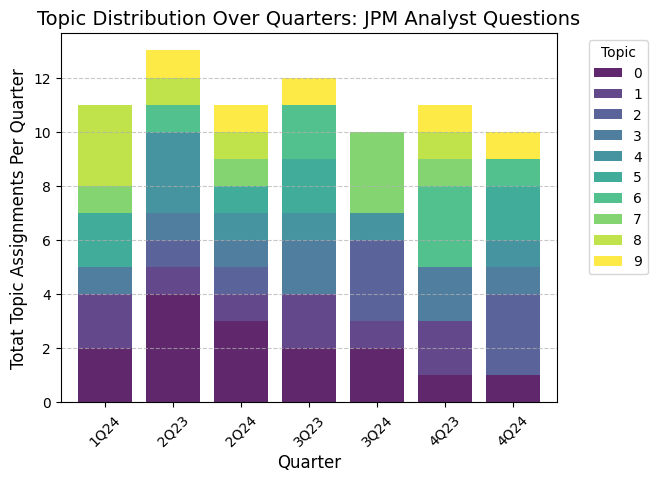

<Figure size 1200x600 with 0 Axes>

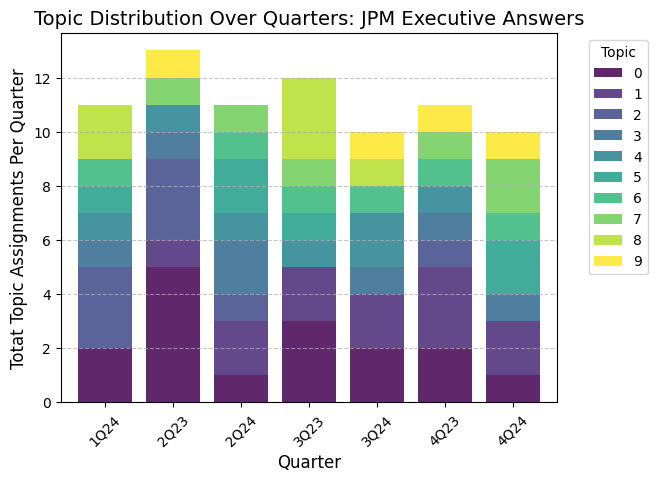

<Figure size 1200x600 with 0 Axes>

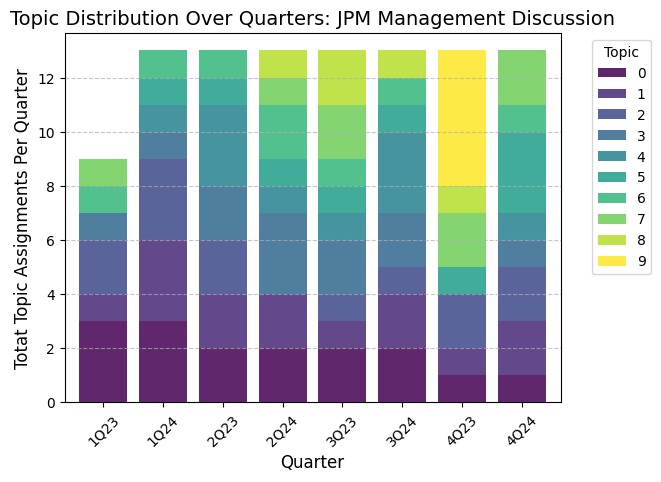


 Visualizing Topic Trends for UBS...


<Figure size 1200x600 with 0 Axes>

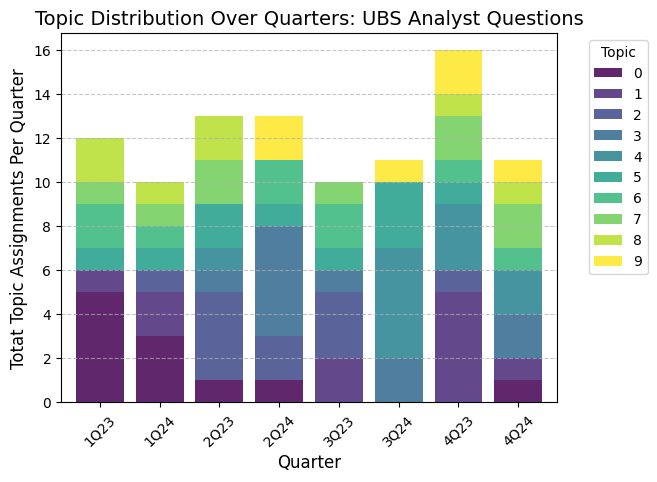

<Figure size 1200x600 with 0 Axes>

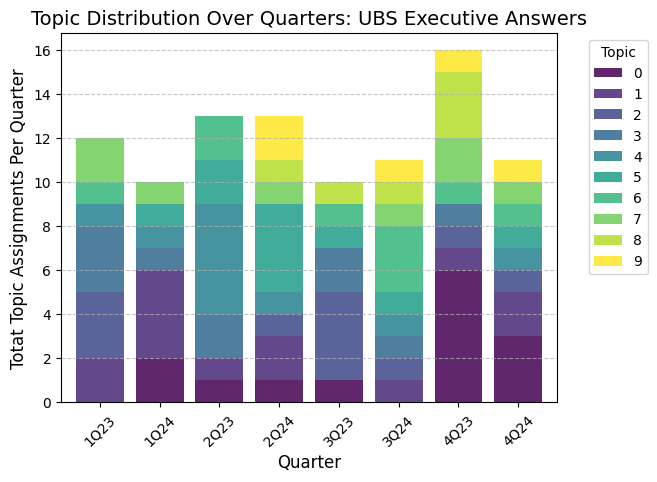

<Figure size 1200x600 with 0 Axes>

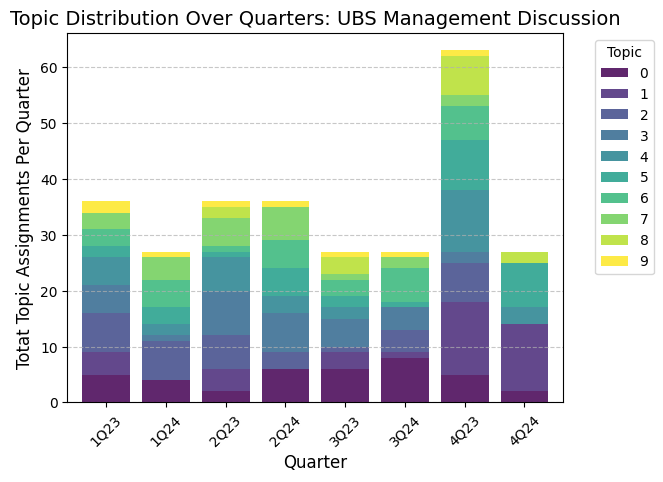

In [27]:
# Plot topic trends over time

def plot_topic_trends(topic_distribution, bank_name, section):
    plt.figure(figsize=(12, 6))

    topic_distribution.plot(kind="bar", stacked=True, colormap="viridis", width=0.8, alpha=0.85)

    plt.title(f"Topic Distribution Over Quarters: {bank_name} {section}", fontsize=14)
    plt.xlabel("Quarter", fontsize=12)
    plt.ylabel("Totat Topic Assignments Per Quarter", fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

print("\n Visualizing Topic Trends for JPM...")
plot_topic_trends(analyst_topic_distribution_jpm, "JPM", "Analyst Questions")
plot_topic_trends(executive_topic_distribution_jpm, "JPM", "Executive Answers")
plot_topic_trends(mgmt_topic_distribution_jpm, "JPM", "Management Discussion")

print("\n Visualizing Topic Trends for UBS...")
plot_topic_trends(analyst_topic_distribution_ubs, "UBS", "Analyst Questions")
plot_topic_trends(executive_topic_distribution_ubs, "UBS", "Executive Answers")
plot_topic_trends(mgmt_topic_distribution_ubs, "UBS", "Management Discussion")

- JPM Analyst Questions remain stable across quarters, with a consistent focus on capital strategy, loan growth, and macroeconomic conditions.
- UBS Analyst Questions show a **major spike in 4Q23**, likely driven by analyst scrutiny over Credit Suisse integration, client retention, and cost-cutting measures.

- JPM Executive Answers exhibit steady topic representation, but **3Q24 and 4Q24 show lower diversity**, suggesting a more controlled and uniform messaging strategy.
- UBS Executive Answers **peaked in 4Q23**, indicating high scrutiny and concern over risk-weighted assets and capital buffers, before declining—potentially signaling either stabilization or reduced transparency.

- JPM Management Discussion remains structured and stable, with **higher topic volume in 1Q24 and 4Q23**, likely reflecting earnings volatility or regulatory focus.
- UBS Management Discussion shows an extreme **spike in 4Q23**, aligning with post-acquisition challenges and financial restructuring concerns.


- **Potential Risk Indicators (JPM)**: Gradual topic convergence suggests controlled messaging but could obscure emerging risks.
- **Potential Risk Indicators (UBS)**: The dramatic 4Q23 spike across all sections signals a high-risk quarter, but the sharp drop afterward may indicate either stabilization or reduced discussion of key risks.

Comparative Takeaway: UBS shows higher volatility in topic focus, reflecting a more reactive environment, while JPM’s structured topic distribution suggests greater strategic stability.

Next Steps: Investigating sentiment shifts and correlating topic changes with external financial events (e.g., macroeconomic conditions, regulatory shifts) could enhance risk detection.


**This data supports earlier hypothesis that new topic emergence and increased topic diversity may be linked to external events and the macroeconomic situation.
It aligns with the prior findings that macroeconomic uncertainty and external disruptions drive topic shifts, new topic emergence, and variations in discourse intensity. Further sentiment analysis could validate whether these shifts reflect proactive strategy adjustments or reactive risk management.**

- UBS’s 4Q23 surge in analyst scrutiny, executive responses, and management discussion suggests a reactionary shift, likely driven by the fallout of the Credit Suisse acquisition and subsequent financial restructuring. This aligns with a major external event impacting UBS.

- JPM’s steadier topic distribution indicates a more controlled narrative, yet minor spikes in 1Q24 and 4Q23 suggest reactions to macroeconomic trends, possibly Federal Reserve policy decisions, capital requirements, or liquidity concerns.

- The drop in UBS discussion intensity post-4Q23 suggests either stabilization or a strategic reduction in transparency, further reinforcing the idea that macroeconomic turbulence and external pressures temporarily drive heightened discourse.

- Diversity of topics tends to increase during volatile periods, supporting the idea that banks adjust their messaging in response to emerging risks, regulatory shifts, and analyst concerns.

- JPM's gradual topic convergence could indicate either internal confidence or controlled messaging, while UBS’s volatile topic engagement suggests reactive adaptation to external pressures.


 Visualizing Topic Evolution for JPM...


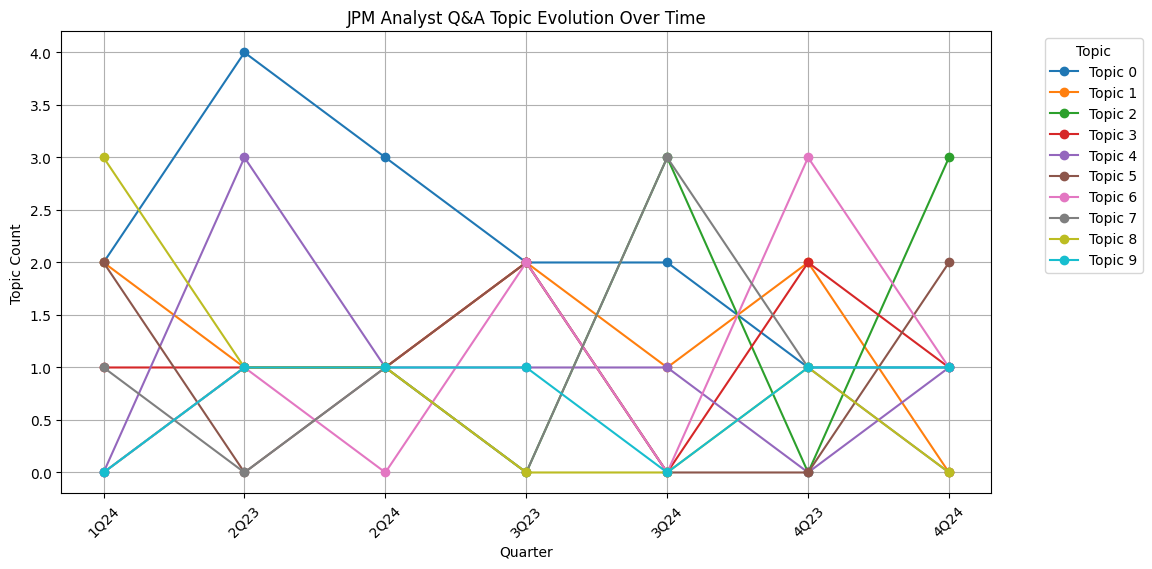

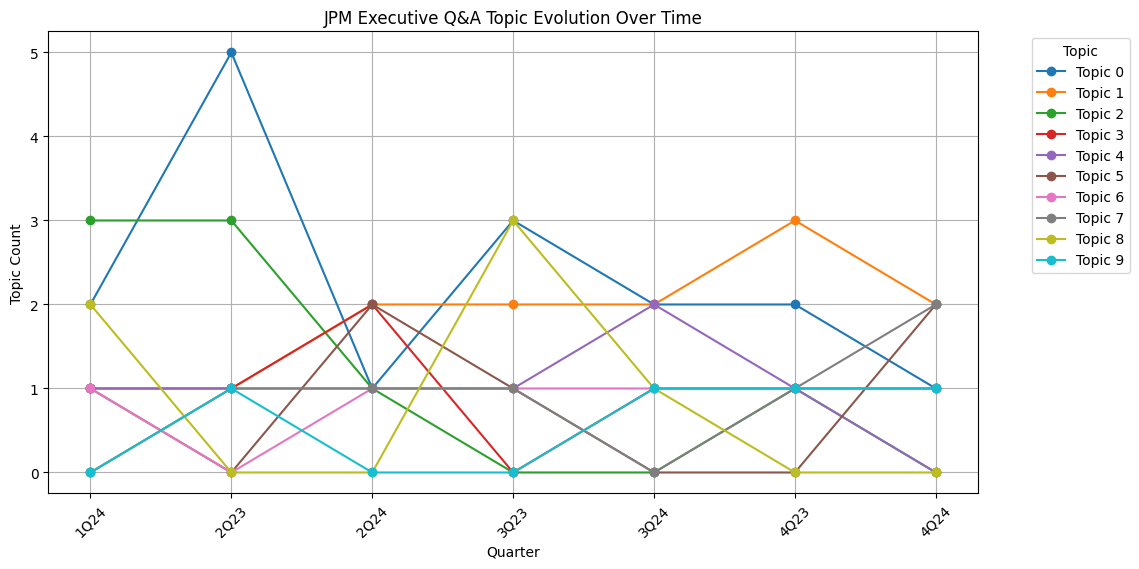

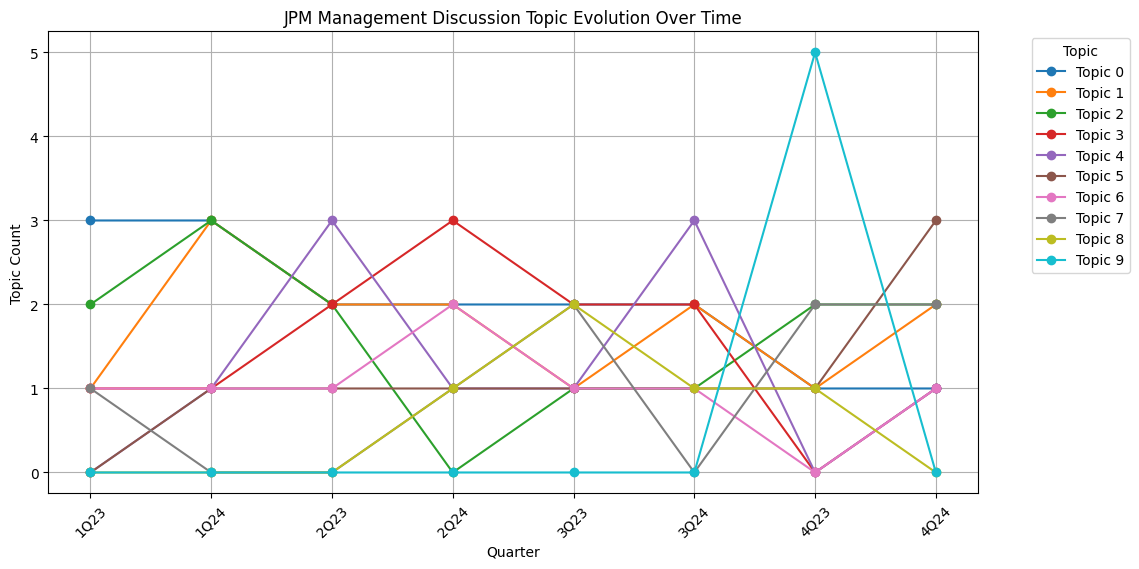


 Visualizing Topic Evolution for UBS...


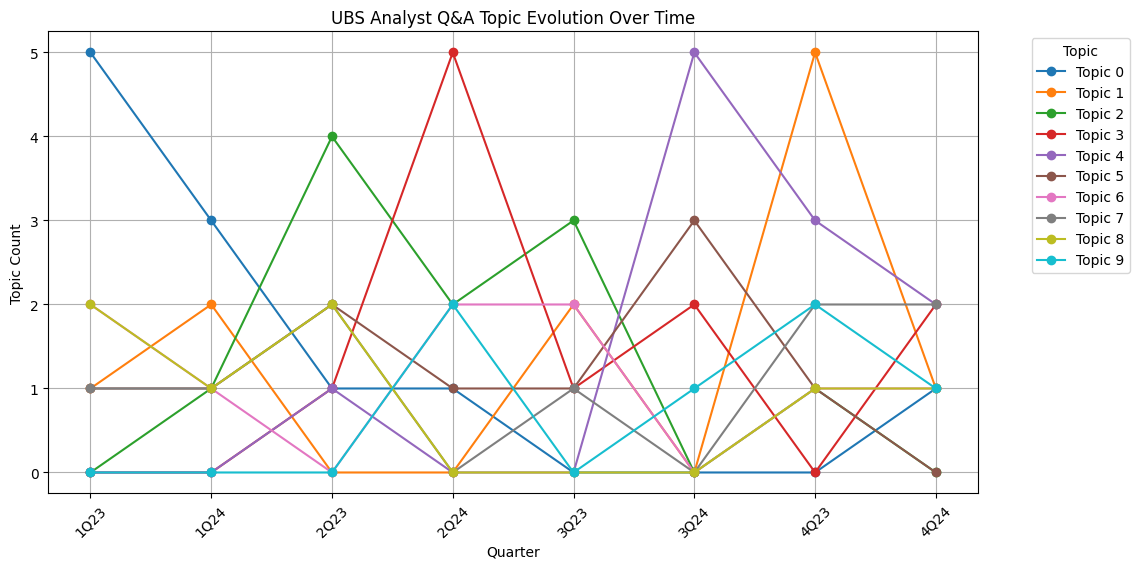

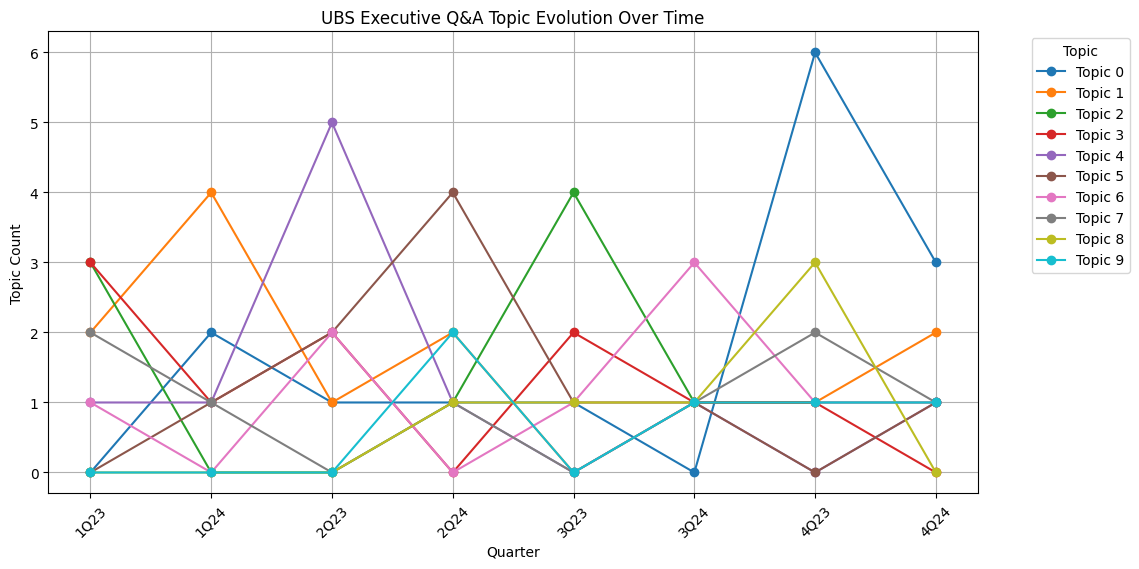

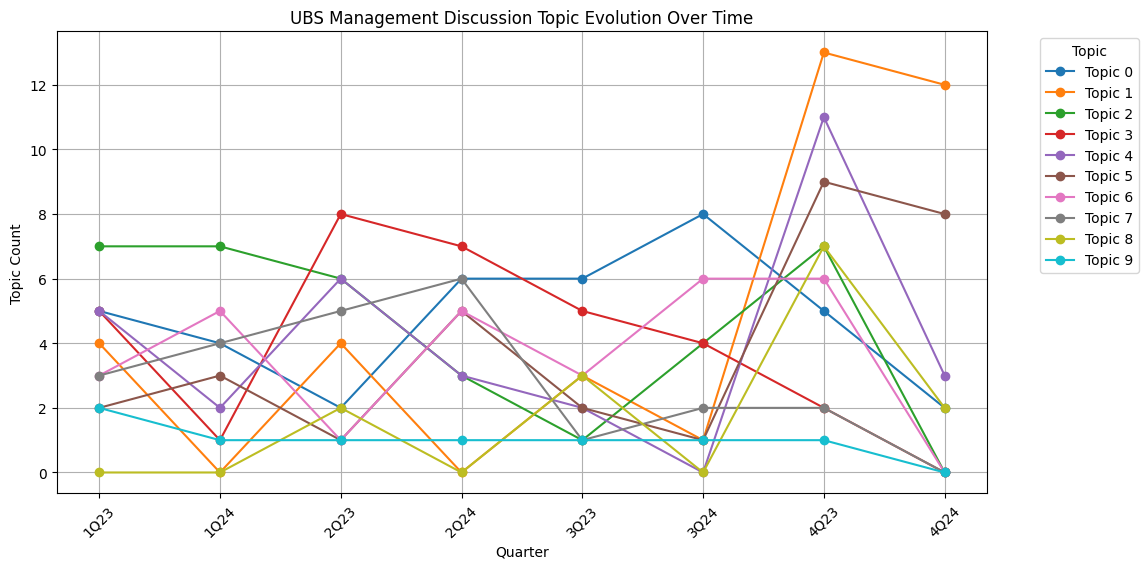

In [28]:
# Alternative visualisation of topic evolution

def plot_topic_evolution(topic_distribution, bank_name, section):
    plt.figure(figsize=(12, 6))
    for topic in topic_distribution.columns:
        plt.plot(topic_distribution.index, topic_distribution[topic], marker='o', linestyle='-', label=f"Topic {topic}")

    plt.title(f"{bank_name} {section} Topic Evolution Over Time")
    plt.xlabel("Quarter")
    plt.ylabel("Topic Count")
    plt.xticks(rotation=45)
    plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.show()

print("\n Visualizing Topic Evolution for JPM...")
plot_topic_evolution(analyst_topic_distribution_jpm, "JPM", "Analyst Q&A")
plot_topic_evolution(executive_topic_distribution_jpm, "JPM", "Executive Q&A")
plot_topic_evolution(mgmt_topic_distribution_jpm, "JPM", "Management Discussion")

print("\n Visualizing Topic Evolution for UBS...")
plot_topic_evolution(analyst_topic_distribution_ubs, "UBS", "Analyst Q&A")
plot_topic_evolution(executive_topic_distribution_ubs, "UBS", "Executive Q&A")
plot_topic_evolution(mgmt_topic_distribution_ubs, "UBS", "Management Discussion")

# 4. Measure tone with sentiment analysis (finBERT)

## 4b) Run FinBERT

In [38]:
# Get data for sentiment analysis

sentiment_datasets = {
    "JPM Analyst Questions": analyst_questions_jpm,
    "JPM Executive Answers": executive_answers_jpm,
    "JPM Management Discussion": expanded_mgmt_jpm,
    "UBS Analyst Questions": analyst_questions_ubs,
    "UBS Executive Answers": executive_answers_ubs,
    "UBS Management Discussion": expanded_mgmt_ubs
}

print(" Checking Sentiment Analysis Datasets:\n")

for name, data in sentiment_datasets.items():
    print(f" {name}:")

    if isinstance(data, list):
        print(f" Data Loaded - Total Entries: {len(data)}")
    else:
        print(f" Unexpected Format in {name} - Expected List, Found {type(data)}")
    print(" Sample Data:", data[:2], "\n")

print(" Step 1 Complete: Data ready for sentiment analysis!")

 Checking Sentiment Analysis Datasets:

 JPM Analyst Questions:
 Data Loaded - Total Entries: 78
 Sample Data: ['jeremy wanted ask capital know get question lot kind high-class dilemma growing capital base perspective earnings store guess whats framework thinking opportunity cost sitting growing base capital high might let go versus patience waiting attractive deployment opportunities you jeremy follow-up think investment spend agenda year differ from say last year last couple years across lines business kind certainty return spectrum talked about kind efficiencies baked outlook helpful you', 'simple difficult guess jamie whos successor second question is know asked question investor day stay ceo little bit longer think hearing investors now goes down think investors would stay say going stay less five years finally getting wanted years spaghetti chart regulatory structure unpredictability capital requirements regulatory costs seems finally getting playing for stay around bit longer in

In [39]:
# Run sentiment analysis with FinBERT

sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert", tokenizer="ProsusAI/finbert")

def run_sentiment_analysis(dataset_dict):
    sentiment_results = {}

    for dataset_name, texts in dataset_dict.items():
        print(f"\n Running Sentiment Analysis on {dataset_name}...")

        sentiments = sentiment_pipeline(texts, truncation=True, max_length=512)
        sentiment_labels = [result["label"] for result in sentiments]
        sentiment_results[dataset_name] = sentiment_labels

        print(f" Completed: {dataset_name}")
        print(f" Sentiment Distribution: {pd.Series(sentiment_labels).value_counts().to_dict()}")

    return sentiment_results

sentiment_results = run_sentiment_analysis({
    "JPM Analyst Questions": analyst_questions_jpm,
    "JPM Executive Answers": executive_answers_jpm,
    "JPM Management Discussion": expanded_mgmt_jpm,
    "UBS Analyst Questions": analyst_questions_ubs,
    "UBS Executive Answers": executive_answers_ubs,
    "UBS Management Discussion": expanded_mgmt_ubs
})

print("\n Sentiment Analysis Completed for all datasets!")

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu



 Running Sentiment Analysis on JPM Analyst Questions...
 Completed: JPM Analyst Questions
 Sentiment Distribution: {'neutral': 74, 'positive': 3, 'negative': 1}

 Running Sentiment Analysis on JPM Executive Answers...
 Completed: JPM Executive Answers
 Sentiment Distribution: {'neutral': 77, 'positive': 1}

 Running Sentiment Analysis on JPM Management Discussion...
 Completed: JPM Management Discussion
 Sentiment Distribution: {'positive': 51, 'neutral': 33, 'negative': 16}

 Running Sentiment Analysis on UBS Analyst Questions...
 Completed: UBS Analyst Questions
 Sentiment Distribution: {'neutral': 88, 'positive': 7, 'negative': 1}

 Running Sentiment Analysis on UBS Executive Answers...
 Completed: UBS Executive Answers
 Sentiment Distribution: {'neutral': 87, 'positive': 8, 'negative': 1}

 Running Sentiment Analysis on UBS Management Discussion...
 Completed: UBS Management Discussion
 Sentiment Distribution: {'positive': 145, 'neutral': 81, 'negative': 53}

 Sentiment Analysis C

Quick visual inspection of sentiment results that **analysts' questions and executives' answers are overwhelmingly neutral for both JPM and UBS**, with very few positive or negative classifications, suggesting cautious or non-committal language.

However, **management discussions exhibit more sentiment variability**, particularly at UBS, where **positive and negative sentiments are more pronounced**, possibly reflecting a mix of optimism about integration efforts and concerns over restructuring challenges.

## 4c) Plot sentiment distribution and trends

In [40]:
# Sentiment distribution for each data set

def calculate_sentiment_distribution(sentiment_results):
    sentiment_distribution = []

    for dataset_name, sentiments in sentiment_results.items():
        sentiment_counts = pd.Series(sentiments).value_counts(normalize=True) * 100
        sentiment_df = sentiment_counts.reset_index()
        sentiment_df.columns = ["Sentiment", "Percentage"]
        sentiment_df["Dataset"] = dataset_name
        sentiment_distribution.append(sentiment_df)

    return pd.concat(sentiment_distribution, ignore_index=True)

sentiment_overall = calculate_sentiment_distribution(sentiment_results)

print("\n Sentiment Distribution Overview:")
print(sentiment_overall)


 Sentiment Distribution Overview:
   Sentiment  Percentage                    Dataset
0    neutral   94.871795      JPM Analyst Questions
1   positive    3.846154      JPM Analyst Questions
2   negative    1.282051      JPM Analyst Questions
3    neutral   98.717949      JPM Executive Answers
4   positive    1.282051      JPM Executive Answers
5   positive   51.000000  JPM Management Discussion
6    neutral   33.000000  JPM Management Discussion
7   negative   16.000000  JPM Management Discussion
8    neutral   91.666667      UBS Analyst Questions
9   positive    7.291667      UBS Analyst Questions
10  negative    1.041667      UBS Analyst Questions
11   neutral   90.625000      UBS Executive Answers
12  positive    8.333333      UBS Executive Answers
13  negative    1.041667      UBS Executive Answers
14  positive   51.971326  UBS Management Discussion
15   neutral   29.032258  UBS Management Discussion
16  negative   18.996416  UBS Management Discussion


<Figure size 1200x600 with 0 Axes>

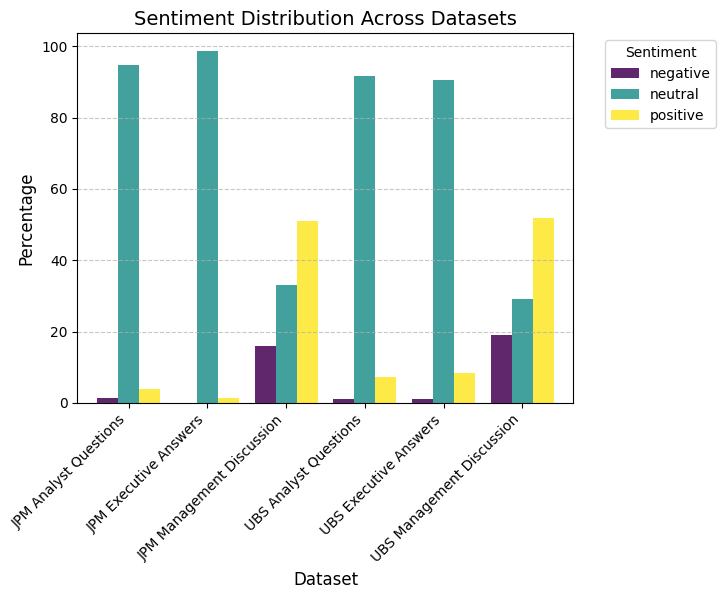

In [42]:
# Plot sentiment distribution per section

def plot_sentiment_distribution_grouped(sentiment_df):
    plt.figure(figsize=(12, 6))

    sentiment_pivot = sentiment_df.pivot(index="Dataset", columns="Sentiment", values="Percentage")

    sentiment_pivot.plot(kind="bar", colormap="viridis", alpha=0.85, width=0.8)

    plt.title("Sentiment Distribution Across Datasets", fontsize=14)
    plt.xlabel("Dataset", fontsize=12)
    plt.ylabel("Percentage", fontsize=12)
    plt.xticks(rotation=45, ha="right")
    plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

plot_sentiment_distribution_grouped(sentiment_overall)

- **Analyst questions and executive answers for both JPM and UBS are overwhelmingly neutral**, with minimal positive or negative sentiment  (reinforcing the idea that these discussions are highly structured, controlled, and carefully worded.)
- In contrast, **management discussions show a mix of positive and negative sentiment**, with JPM and UBS both having over 50% positive sentiment but UBS showing slightly higher negativity (19% vs. 16%), likely reflecting its ongoing Credit Suisse integration.
- Interestingly, UBS analyst and executive responses have a marginally higher positive sentiment than JPM, which could suggest UBS executives are attempting to project optimism despite ongoing challenges.

This indicates that while Q&A sessions remain cautious and controlled, **management discussions provide a more revealing look at both optimism and risk factors, making them valuable for identifying potential early risk indicators**.

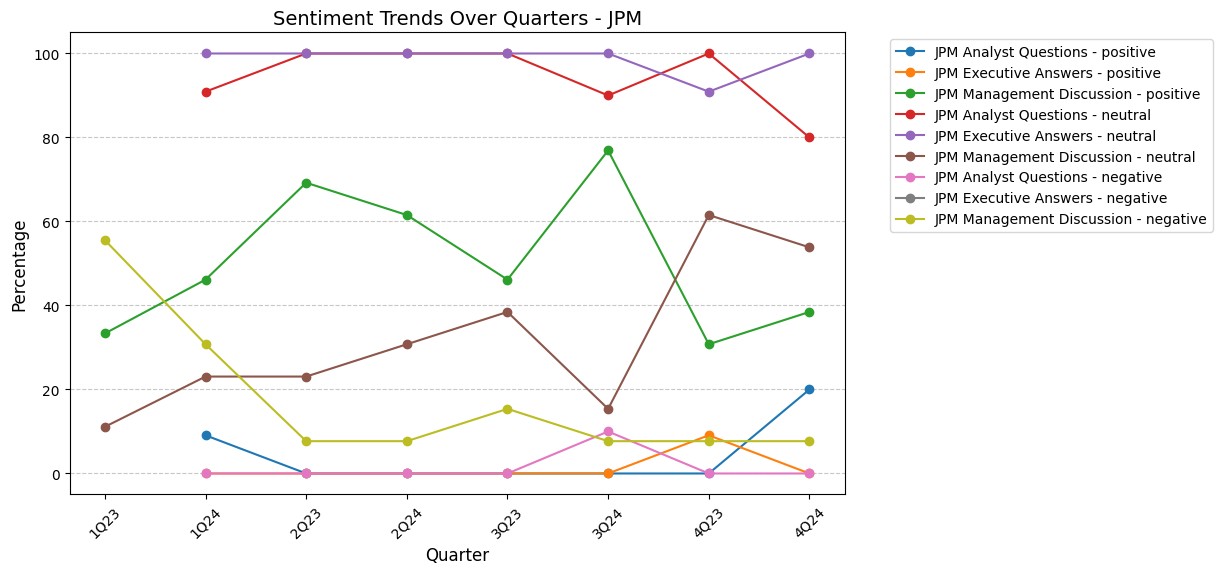

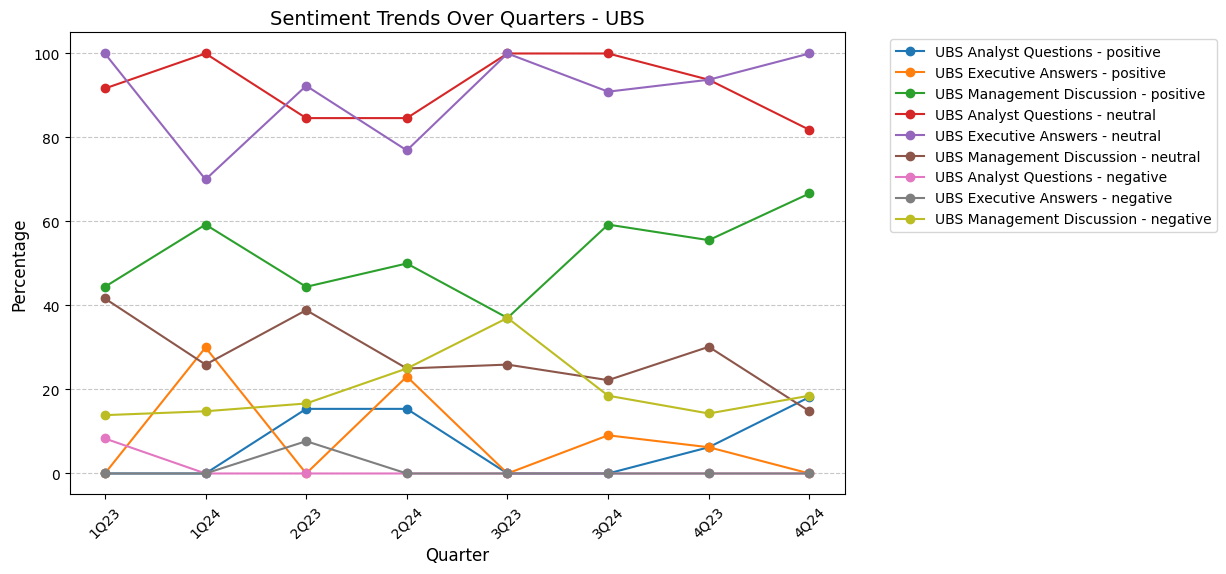

In [46]:
# Analyse sentiment over quarters

df_analyst_topics_jpm["Sentiment"] = sentiment_results["JPM Analyst Questions"]
df_executive_topics_jpm["Sentiment"] = sentiment_results["JPM Executive Answers"]
df_mgmt_topics_jpm["Sentiment"] = sentiment_results["JPM Management Discussion"]

df_analyst_topics_ubs["Sentiment"] = sentiment_results["UBS Analyst Questions"]
df_executive_topics_ubs["Sentiment"] = sentiment_results["UBS Executive Answers"]
df_mgmt_topics_ubs["Sentiment"] = sentiment_results["UBS Management Discussion"]

def compute_sentiment_trends(df, dataset_name):
    sentiment_counts = df.groupby(["Quarter", "Sentiment"]).size().unstack(fill_value=0)
    sentiment_percentages = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0) * 100
    sentiment_percentages["Dataset"] = dataset_name
    return sentiment_percentages.reset_index()

sentiment_trends_jpm = pd.concat([
    compute_sentiment_trends(df_analyst_topics_jpm, "JPM Analyst Questions"),
    compute_sentiment_trends(df_executive_topics_jpm, "JPM Executive Answers"),
    compute_sentiment_trends(df_mgmt_topics_jpm, "JPM Management Discussion")
])

sentiment_trends_ubs = pd.concat([
    compute_sentiment_trends(df_analyst_topics_ubs, "UBS Analyst Questions"),
    compute_sentiment_trends(df_executive_topics_ubs, "UBS Executive Answers"),
    compute_sentiment_trends(df_mgmt_topics_ubs, "UBS Management Discussion")
])

quarter_order = sorted(sentiment_trends_jpm["Quarter"].unique(), key=lambda x: (int(x[-2]), x))

def plot_sentiment_trends(sentiment_trends, bank_name):
    plt.figure(figsize=(10, 6))

    for sentiment in ["positive", "neutral", "negative"]:
        subset = sentiment_trends.melt(id_vars=["Quarter", "Dataset"], value_vars=[sentiment],
                                       var_name="Sentiment", value_name="Percentage")

        for dataset in subset["Dataset"].unique():
            dataset_subset = subset[subset["Dataset"] == dataset]
            dataset_subset = dataset_subset.set_index("Quarter").reindex(quarter_order).reset_index()
            plt.plot(dataset_subset["Quarter"], dataset_subset["Percentage"], marker="o", label=f"{dataset} - {sentiment}")

    plt.xlabel("Quarter", fontsize=12)
    plt.ylabel("Percentage", fontsize=12)
    plt.title(f"Sentiment Trends Over Quarters - {bank_name}", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

plot_sentiment_trends(sentiment_trends_jpm, "JPM")
plot_sentiment_trends(sentiment_trends_ubs, "UBS")

- JPM executive answers and analyst questions remain predominantly neutral, with minor fluctuations, suggesting a stable and cautious communication style. However, JPM’s management discussion sees a mix of sentiment, with **positive sentiment peaking at certain points but also experiencing declines**, indicating moments of optimism and strategic challenges. **Negative sentiment in JPM's management discussion appears sporadic rather than persistent**, suggesting reactionary shifts to specific events rather than a consistent downward trend.

- For UBS, analyst and executive answers also remain largely neutral, but UBS executive sentiment sees a slightly higher positive trend compared to JPM, possibly reflecting confidence in managing post-Credit Suisse integration. UBS management discussions, like JPM, show more variation, with **positive sentiment peaking at some points but also facing dips**, possibly reflecting integration complexities. **Negative sentiment in UBS management discussions is consistently higher than JPM’s**, supporting the view that leadership is dealing with more significant restructuring-related concerns.

Overall, management discussions for both banks seem to be the most revealing in terms of sentiment shifts, while Q&A sessions remain more measured and neutral.

💡**Notably, 4Q23 marks a potential inflection point with data suggesting stabilisation, particularly in management discussions. It is a noteworthy quarter where negative sentiment plateaus or slightly declines. This could mean that prior concerns (such as Credit Suisse integration for UBS or capital/liquidity concerns for JPM) were beginning to stabilize.**

## 4d) Evaluate model performance

In [59]:
# Define financial sentiment keywords for weak supervision

positive_keywords = ["growth", "profit", "increase", "strong", "positive", "gain", "success", "optimistic"]
negative_keywords = ["loss", "decline", "weak", "negative", "risk", "decrease", "concern", "uncertainty"]
neutral_keywords = ["expect", "estimate", "projection", "maintain", "neutral", "steady", "flat"]

def assign_weak_label(text):
    text = text.lower()
    if any(word in text for word in positive_keywords):
        return "positive"
    elif any(word in text for word in negative_keywords):
        return "negative"
    else:
        return "neutral"

In [61]:
# Set aside a random sample from each data set and assign labels

sample_size_jpm = int(0.15 * len(analyst_questions_jpm))
sample_size_ubs = int(0.15 * len(analyst_questions_ubs))

test_data = {
    "JPM Analyst Questions": random.sample(analyst_questions_jpm, sample_size_jpm),
    "JPM Executive Answers": random.sample(executive_answers_jpm, sample_size_jpm),
    "JPM Management Discussion": random.sample(expanded_mgmt_jpm, sample_size_jpm),
    "UBS Analyst Questions": random.sample(analyst_questions_ubs, sample_size_ubs),
    "UBS Executive Answers": random.sample(executive_answers_ubs, sample_size_ubs),
    "UBS Management Discussion": random.sample(expanded_mgmt_ubs, sample_size_ubs)
}

df_test_sentiment = []
for dataset_name, texts in test_data.items():
    df = pd.DataFrame({"Text": texts})
    df["Dataset"] = dataset_name
    df["Weak_Supervision_Label"] = df["Text"].apply(assign_weak_label)
    df_test_sentiment.append(df)

df_test_sentiment = pd.concat(df_test_sentiment, ignore_index=True)

print("\n Sample of Weakly Labeled Test Data:")
print(df_test_sentiment.head())


 Sample of Weakly Labeled Test Data:
                                                Text                Dataset  \
0  wanted ask little bit feeling trade-off commer...  JPM Analyst Questions   
1  hey jamie think seen comment government year t...  JPM Analyst Questions   
2  you want follow -up pricing power conversation...  JPM Analyst Questions   
3  jeremy jamie jeremy you mentioned comments ove...  JPM Analyst Questions   
4  lower rates supposed drive pick-up loan growth...  JPM Analyst Questions   

  Weak_Supervision_Label  
0               positive  
1                neutral  
2                neutral  
3               positive  
4               positive  


In [62]:
# Run FinBERT on labeled test data

sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert", tokenizer="ProsusAI/finbert")
finbert_predictions = sentiment_pipeline(df_test_sentiment["Text"].tolist(), truncation=True, max_length=512)
df_test_sentiment["FinBERT_Sentiment"] = [result["label"] for result in finbert_predictions]

print("\n Sample of Test Data with FinBERT Predictions:")
print(df_test_sentiment.head())

Device set to use cpu



 Sample of Test Data with FinBERT Predictions:
                                                Text                Dataset  \
0  wanted ask little bit feeling trade-off commer...  JPM Analyst Questions   
1  hey jamie think seen comment government year t...  JPM Analyst Questions   
2  you want follow -up pricing power conversation...  JPM Analyst Questions   
3  jeremy jamie jeremy you mentioned comments ove...  JPM Analyst Questions   
4  lower rates supposed drive pick-up loan growth...  JPM Analyst Questions   

  Weak_Supervision_Label FinBERT_Sentiment  
0               positive           neutral  
1                neutral           neutral  
2                neutral           neutral  
3               positive           neutral  
4               positive           neutral  


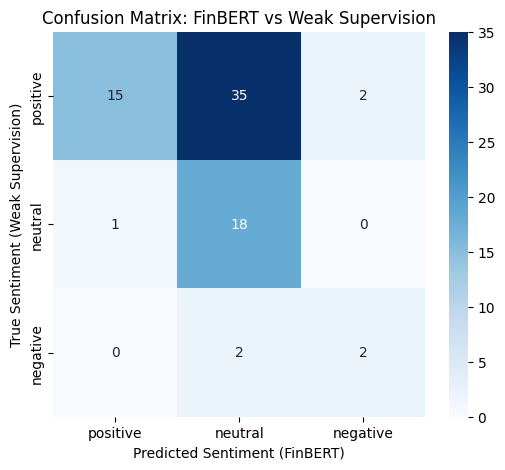


🔍 Classification Report (FinBERT vs Weak Supervision):
              precision    recall  f1-score   support

    positive       0.50      0.50      0.50         4
     neutral       0.33      0.95      0.49        19
    negative       0.94      0.29      0.44        52

    accuracy                           0.47        75
   macro avg       0.59      0.58      0.48        75
weighted avg       0.76      0.47      0.46        75



In [63]:
# Evaluate performance

true_labels = df_test_sentiment["Weak_Supervision_Label"]
predicted_labels = df_test_sentiment["FinBERT_Sentiment"]
cm = confusion_matrix(true_labels, predicted_labels, labels=["positive", "neutral", "negative"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["positive", "neutral", "negative"],
            yticklabels=["positive", "neutral", "negative"])
plt.xlabel("Predicted Sentiment (FinBERT)")
plt.ylabel("True Sentiment (Weak Supervision)")
plt.title("Confusion Matrix: FinBERT vs Weak Supervision")
plt.show()

print("\n Classification Report (FinBERT vs Weak Supervision):")
print(classification_report(true_labels, predicted_labels, target_names=["positive", "neutral", "negative"]))

Evaluation shows that FinBERT
- is heavily biased toward predicting 'neutral' sentiment
- positive and negative sentiment detection is weak
- overall accuracy of 47% is low, meaning FinBERT only aligns with weak supervision about half the time
- weighted F1-score (46%) also indicates poor balance across classes

**FinBERT is struggling to distinguish sentiment extremes** (positive & negative) in financial text.

Neutral dominance suggests the **need for fine-tuning** on financial datasets or adjusting decision thresholds.

Weak supervision might also be imperfect, so manual review of misclassified samples could help.


# 5. Save BERTopic and FinBERT results as csvs

In [71]:
# Save BERTopic & FinBERT results to google drive

file_path_bert_jpm_questions = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/bertopic_finbert_output/JPM_questions_topics_050325_v1.csv"
file_path_bert_jpm_answers = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/bertopic_finbert_output/JPM_answers_topics_050325_v1.csv"
file_path_bert_jpm_mgmt = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/bertopic_finbert_output/JPM_mgmt_topics_050325_v1.csv"

file_path_bert_ubs_questions = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/bertopic_finbert_output/UBS_questions_topics_050325_v1.csv"
file_path_bert_ubs_answers = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/bertopic_finbert_output/UBS_answers_topics_050325_v1.csv"
file_path_bert_ubs_mgmt = "/content/drive/MyDrive/BOE/bank_of_england/data/model_outputs/bertopic_finbert_output/UBS_mgmt_topics_050325_v1.csv"

df_topics_jpm_questions.to_csv(file_path_bert_jpm_questions, index=False)
df_topics_jpm_answers.to_csv(file_path_bert_jpm_answers, index=False)
df_topics_jpm_mgmt.to_csv(file_path_bert_jpm_mgmt, index=False)

df_topics_ubs_questions.to_csv(file_path_bert_ubs_questions, index=False)
df_topics_ubs_answers.to_csv(file_path_bert_ubs_answers, index=False)
df_topics_ubs_mgmt.to_csv(file_path_bert_ubs_mgmt, index=False)

print("\n BERTopic results saved successfully to Google Drive!")


 BERTopic results saved successfully to Google Drive!
